### Analysis notebook for Dynamical Sculpting project (codename: mastrangelo). 

In response to referee comments for the manuscript, the following changes have been introduced to the planet population synthesis code, as well as the log-likelihood calculation:
- Draw ages from asymmetric errors, following the prescription from https://iopscience.iop.org/article/10.3847/1538-3881/abd93f (simulate_helpers.py)
- Draw eccentricities from Rayleigh distributions, a la Van Eylen+ 2018 (simulate_transit.py)
- Make sure ages < 0 are redrawn (simulate_helpers.py)
- Save 3 logLs, one for each indicator (collect_simulations.py)

In [1]:
%pip install seaborn

import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
from glob import glob
import matplotlib.pyplot as plt
import scipy
from math import lgamma
import seaborn as sns
from matplotlib.ticker import MaxNLocator

%matplotlib inline

path = '/Users/chrislam/Desktop/mastrangelo/'


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pylab as pylab
pylab_params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(pylab_params)

total_stars = 67380

In [3]:
import sys 
print(sys.executable)
print(sys.path)

/Library/Frameworks/Python.framework/Versions/3.12/bin/python3.12
['/Users/chrislam/Desktop/mastrangelo/notebooks', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages']


In [4]:
from ast import literal_eval

#https://stackoverflow.com/questions/52232742/how-to-use-ast-literal-eval-in-a-pandas-dataframe-and-handle-exceptions
def literal_eval_w_exceptions(x):
    try:
        return literal_eval(str(x))   
    except Exception as e:
        #print(e)
        pass

#### Let's make sure the ages were actually sampled the way we wanted them. 

In [6]:
test = pd.read_csv(path+'data/transits4_2_10_21.csv', sep='\t', on_bad_lines='skip')
test[['age','iso_age','iso_age_err1','iso_age_err2']].iloc[0:40]

,age,iso_age,iso_age_err1,iso_age_err2
0,1.493124,1.24,0.20,-0.16
1,19.973917,14.31,3.50,-4.61
2,19.973917,14.31,3.50,-4.61
3,1.915459,1.56,0.32,-0.28
4,1.735694,1.85,0.09,-0.12
5,1.735694,1.85,0.09,-0.12
6,1.553368,1.44,0.11,-0.30
7,2.381632,2.14,0.43,-0.42
8,2.381632,2.14,0.43,-0.42
9,8.491703,7.20,3.31,-3.00


In [13]:
test = pd.read_csv(path+'data/transits4_2_10_22.csv', sep='\t', on_bad_lines='skip')
test[['age','iso_age','iso_age_err1','iso_age_err2']].iloc[0:40]

,age,iso_age,iso_age_err1,iso_age_err2
0,1.459596,1.24,0.20,-0.16
1,1.459596,1.24,0.20,-0.16
2,8.656566,14.31,3.50,-4.61
3,8.656566,14.31,3.50,-4.61
4,1.075758,1.56,0.32,-0.28
5,1.075758,1.56,0.32,-0.28
6,1.843434,1.85,0.09,-0.12
7,1.843434,1.85,0.09,-0.12
8,1.267677,1.44,0.11,-0.30
9,1.267677,1.44,0.11,-0.30


#### Back to the show

Read in files. For each recovery DataFrame per model, calculate the geometric and detected transit multiplicity. For each model, plot the 30 recovery multiplicities over the single ground truth one. There should be one plus (three times two times three) models, or 19 different models. Which models have greater spread? Let's find out!

In [7]:
#truth = pd.read_csv(path+'data/collect_ground_truth2_old.csv', converters=dict(transit_multiplicities=literal_eval))
truth = pd.read_csv(path+'data/collect_asymmetric.csv', converters=dict(transit_multiplicities=literal_eval))
truth

,ms,bs,cs,fs,transit_multiplicities,geom_transit_multiplicities,intact_fracs,disrupted_fracs,logLs,logLs_score,logLs_fpp
0,-1.0,0.0,1.000000e+08,0.1,"[203.9, 10.5, 0.0, 0.0, 0.0, 0.0]","[406.8, 37.9, 0.0, 0.0, 0.0, 0.0]",0.0,0.1,-904.298749,-563.759992,-1219.360471
1,-1.0,0.0,1.000000e+08,0.2,"[407.8, 21.0, 0.0, 0.0, 0.0, 0.0]","[813.6, 75.8, 0.0, 0.0, 0.0, 0.0]",0.0,0.2,-448.425425,-261.072195,-599.904413
2,-1.0,0.0,1.000000e+08,0.3,"[611.6999999999999, 31.5, 0.0, 0.0, 0.0, 0.0]","[1220.3999999999999, 113.7, 0.0, 0.0, 0.0, 0.0]",0.0,0.3,-270.740666,-172.995224,-326.529888
3,-1.0,0.0,1.000000e+08,0.4,"[815.6, 42.0, 0.0, 0.0, 0.0, 0.0]","[1627.2, 151.6, 0.0, 0.0, 0.0, 0.0]",0.0,0.4,-206.952101,-172.784398,-194.848355
4,-1.0,0.0,1.000000e+08,0.5,"[1019.5, 52.5, 0.0, 0.0, 0.0, 0.0]","[2034.0, 189.5, 0.0, 0.0, 0.0, 0.0]",0.0,0.5,-205.572287,-220.719309,-140.806662
...,...,...,...,...,...,...,...,...,...,...,...
7915,0.0,1.0,1.000000e+10,0.6,"[1462.2, 716.4, 357.59999999999997, 137.4, 45....","[1587.0, 1066.8, 828.0, 550.1999999999999, 269...",0.6,0.0,-889.407858,-1090.768071,-843.031562
7916,0.0,1.0,1.000000e+10,0.7,"[1705.8999999999999, 835.8, 417.2, 160.2999999...","[1851.4999999999998, 1244.6, 965.9999999999999...",0.7,0.0,-1185.203411,-1422.480733,-1104.297363
7917,0.0,1.0,1.000000e+10,0.8,"[1949.6000000000001, 955.2, 476.8, 183.2000000...","[2116.0, 1422.4, 1104.0, 733.6, 359.2000000000...",0.8,0.0,-1502.133734,-1770.523870,-1391.316654
7918,0.0,1.0,1.000000e+10,0.9,"[2193.3, 1074.6000000000001, 536.4, 206.1, 68....","[2380.5, 1600.2, 1242.0, 825.3000000000001, 40...",0.9,0.0,-1835.206122,-2131.039706,-1698.005642


In [8]:
recovery = pd.read_csv(path+'data/collect_recovery_asymmetric.csv', converters=dict(transit_multiplicities=literal_eval))
#recovery = recovery.loc[~(np.round(recovery.cs, -7) == 1.6e8)] # I had to redo 1.6e8 cutoff time bc of a bug
recovery

,ms,bs,cs,fs,transit_multiplicities,geom_transit_multiplicities,intact_fracs,disrupted_fracs,logLs,logLs_score,logLs_fpp
0,-1.0,0.0,1.000000e+08,0.1,"[197.0, 11.3, 0.0, 0.0, 0.0, 0.0]","[394.8, 36.6, 0.0, 0.0, 0.0, 0.0]",0.0,0.1,-917.036283,-570.938606,-1242.271745
1,-1.0,0.0,1.000000e+08,0.1,"[196.8, 10.3, 0.0, 0.0, 0.0, 0.0]","[403.1, 36.300000000000004, 0.0, 0.0, 0.0, 0.0]",0.0,0.1,-929.098681,-581.035306,-1252.832640
2,-1.0,0.0,1.000000e+08,0.1,"[198.9, 10.700000000000001, 0.0, 0.0, 0.0, 0.0]","[401.5, 35.7, 0.0, 0.0, 0.0, 0.0]",0.0,0.1,-917.651672,-572.456263,-1239.402906
3,-1.0,0.0,1.000000e+08,0.1,"[198.20000000000002, 12.600000000000001, 0.0, ...","[401.0, 34.5, 0.0, 0.0, 0.0, 0.0]",0.0,0.1,-899.885755,-557.083791,-1225.641617
4,-1.0,0.0,1.000000e+08,0.1,"[183.5, 9.8, 0.0, 0.0, 0.0, 0.0]","[388.0, 35.0, 0.0, 0.0, 0.0, 0.0]",0.0,0.1,-980.254497,-617.111043,-1320.886182
...,...,...,...,...,...,...,...,...,...,...,...
237595,0.0,1.0,1.000000e+10,1.0,"[2401.0, 1205.0, 582.0, 233.0, 60.0, 6.0]","[2607.0, 1751.0, 1364.0, 938.0, 421.0, 90.0]",1.0,0.0,-2143.005292,-2460.263432,-1985.709364
237596,0.0,1.0,1.000000e+10,1.0,"[2374.0, 1232.0, 602.0, 229.0, 72.0, 12.0]","[2566.0, 1812.0, 1328.0, 966.0, 457.0, 104.0]",1.0,0.0,-2181.520594,-2497.213799,-2027.925385
237597,0.0,1.0,1.000000e+10,1.0,"[2409.0, 1164.0, 544.0, 236.0, 48.0, 11.0]","[2659.0, 1713.0, 1309.0, 898.0, 407.0, 100.0]",1.0,0.0,-2073.362726,-2390.070769,-1913.921225
237598,0.0,1.0,1.000000e+10,1.0,"[2340.0, 1134.0, 567.0, 221.0, 71.0, 11.0]","[2520.0, 1768.0, 1333.0, 854.0, 457.0, 103.0]",1.0,0.0,-2030.523321,-2341.176565,-1878.550794


In [67]:
best_logL = np.nanmax(recovery.logLs)
best_logL_score = np.nanmax(recovery.logLs_score)
best_logL_fpp = np.nanmax(recovery.logLs_fpp)

good_models = recovery.loc[np.abs(recovery.logLs - best_logL) <= delta_logL]
good_models_score = recovery.loc[np.abs(recovery.logLs_score - best_logL_score) <= delta_logL]
good_models_fpp = recovery.loc[np.abs(recovery.logLs_fpp - best_logL_fpp) <= delta_logL]

k = pd.Series([833, 134, 38, 15, 5, 0])
k_score = pd.Series([631, 115, 32, 10, 4, 0])
k_fpp = pd.Series([1088, 115, 34, 9, 3, 0])

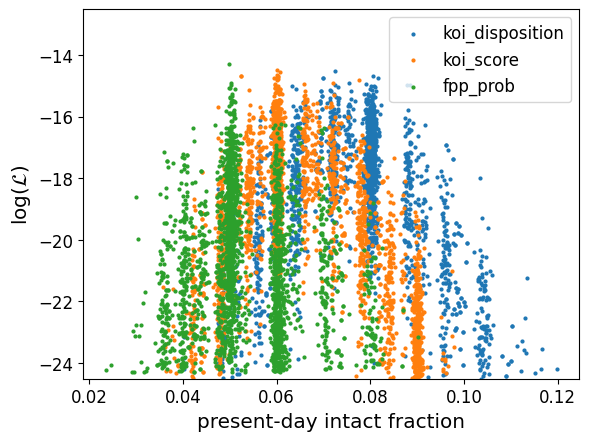

what to quote:  0.0401639344262295 0.07786551946451321 0.1198164396213345
koi_disposition:  0.0798833987531748
koi_score:  0.0605749249595936
fpp_prob:  0.0505368275225121


In [102]:
plt.scatter(good_models.intact_fracs, 
            good_models.logLs, s=4, label='koi_disposition')
plt.scatter(good_models_score.intact_fracs, 
            good_models_score.logLs_score, s=4, label='koi_score')
plt.scatter(good_models_fpp.intact_fracs, 
            good_models_fpp.logLs_fpp, s=4, label='fpp_prob')
plt.ylabel('logL')
plt.xlabel('intact fraction')
plt.xlabel('present-day intact fraction')
plt.ylabel(r'log($\mathcal{L}$)')
plt.ylim([good_models.logLs.min(), good_models.logLs.max()+2])
plt.legend()
plt.savefig(path+'figures/intact-vs-logL-indicators.png')

plt.show()

print("what to quote: ", np.min(good_models.intact_fracs), np.mean(good_models.intact_fracs), np.max(good_models.intact_fracs))
print("koi_disposition: ", np.median(good_models.intact_fracs))
print("koi_score: ", np.median(good_models_score.intact_fracs))
print("fpp_prob: ", np.median(good_models_fpp.intact_fracs))

Intact fractions for all models

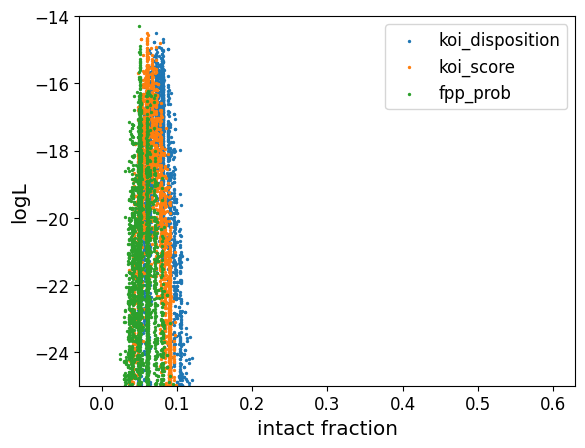

In [97]:
"""
plt.scatter(recovery.intact_fracs, 
            recovery.logLs, s=2, label='koi_disposition')
plt.scatter(recovery.intact_fracs, 
            recovery.logLs_score, s=2, label='koi_score')
plt.scatter(recovery.intact_fracs, 
            recovery.logLs_fpp, s=2, label='fpp_prob')
"""
#"""
# this is to see if, given their respective best planet-host fraction, any indicator has good intact fractions with bad logL
plt.scatter(recovery.loc[recovery.fs == 0.4].intact_fracs, 
            recovery.loc[recovery.fs == 0.4].logLs, s=2, label='koi_disposition')
plt.scatter(recovery.loc[recovery.fs == 0.3].intact_fracs, 
            recovery.loc[recovery.fs == 0.3].logLs_score, s=2, label='koi_score')
plt.scatter(recovery.loc[(recovery.fs == 0.5) | (recovery.fs == 0.6)].intact_fracs, 
            recovery.loc[(recovery.fs == 0.5) | (recovery.fs == 0.6)].logLs_fpp, s=2, label='fpp_prob')
#"""
plt.ylabel('logL')
plt.xlabel('intact fraction')
plt.legend()
plt.ylim([-25, -14])
#plt.xlim([0.04, 0.11])
plt.show()

Ok, good. I was looking to see whether 1) there was no good model that was outside that intact fraction, and whether 2) there were no bad models that gave the good intact fraction.

Plot posteriors. The recovery file serves two purposes: 1) injection-recovery, in order to evaluate our machinery's validatity for ground truths that span different corners of our sculpting law parameter space; and 2) just straight up using the logLs in order to forward model the best sculpting law, given the observed Kepler transit multiplicity. The injection-recovery notebook (https://github.com/exoclam/mastrangelo/blob/main/notebooks/injection-recovery.ipynb) deals with 1). Here, we do 2). 

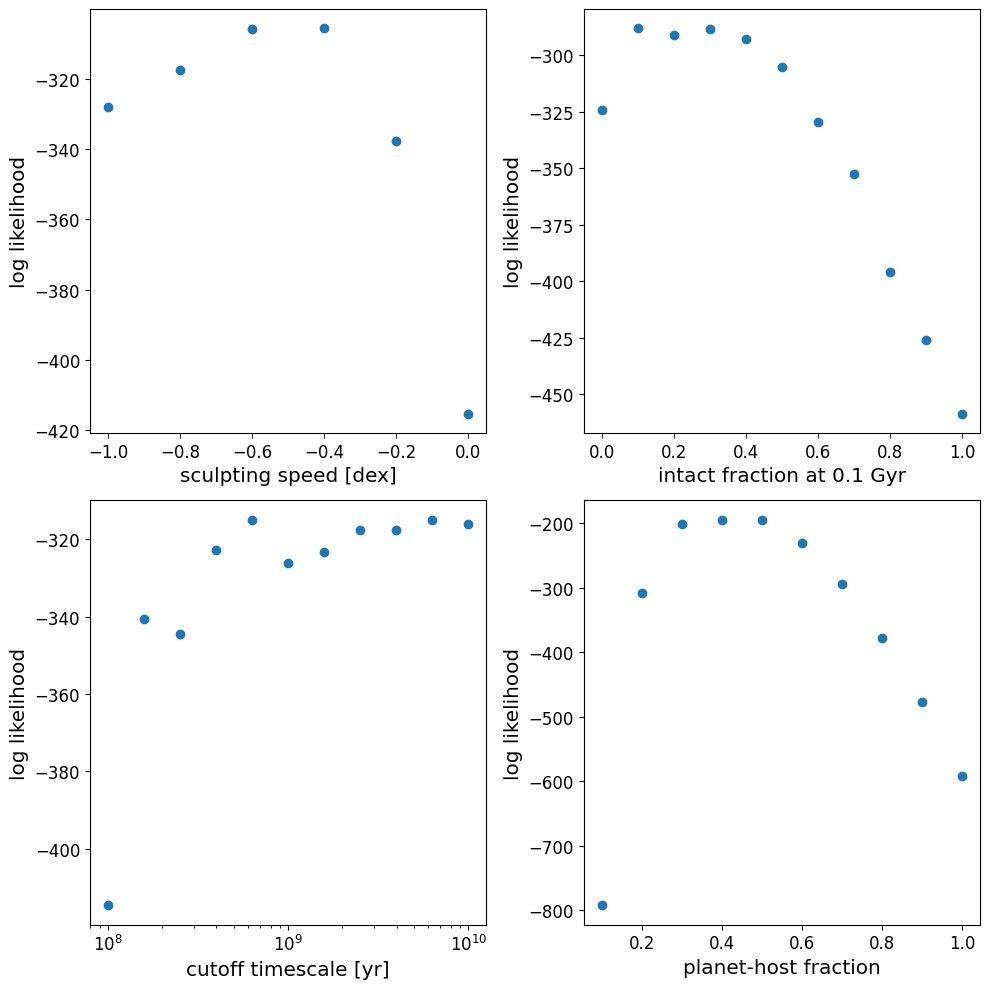

In [13]:
cube = [0, 0, 0]
fs = np.round(np.linspace(0.1, 1., 10), 1)
ndim = 3
nparams = 3

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# marginalize in 1D
marginalized_logLs = []
for gi_m in np.sort(recovery.ms.unique()):
    
    # subset
    only = recovery.loc[(recovery.ms == gi_m)]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.median(only.logLs))

ax1.scatter(np.sort(recovery.ms.unique()), marginalized_logLs)
ax1.set_ylabel("log likelihood")
ax1.set_xlabel("sculpting speed [dex]")

marginalized_logLs = []
for gi_b in np.sort(recovery.bs.unique()):
        
    # subset
    only = recovery.loc[(recovery.bs == gi_b)]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.median(only.logLs))
ax2.scatter(np.sort(recovery.bs.unique()), marginalized_logLs)
ax2.set_ylabel("log likelihood")
ax2.set_xlabel("intact fraction at 0.1 Gyr")

marginalized_logLs = []
for gi_c in np.sort(recovery.cs.unique()):
    
    # subset
    only = recovery.loc[(recovery.cs == gi_c)]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.median(only.logLs))
ax3.scatter(np.sort(recovery.cs.unique()), marginalized_logLs)
ax3.set_ylabel("log likelihood")
ax3.set_xlabel("cutoff timescale [yr]")
ax3.set_xscale('log')

marginalized_logLs = []
for gi_f in np.linspace(0.1, 1, 10):
    
    # subset
    only = recovery.loc[(np.round(recovery.fs, 1) == np.round(gi_f, 1))]
    
    # marginalize logL
    marginalized_logLs.append(np.median(only.logLs))
ax4.scatter(np.linspace(0.1, 1, 10), marginalized_logLs)
ax4.set_ylabel("log likelihood")
ax4.set_xlabel("planet-host fraction")

plt.tight_layout()
plt.show()

In [51]:
recovery.loc[recovery.logLs > -15]

,ms,bs,cs,fs,transit_multiplicities,geom_transit_multiplicities,intact_fracs,disrupted_fracs,logLs,logLs_score,logLs_fpp
66116,-0.8,0.7,3.981072e+08,0.4,"[837.6, 135.6, 38.800000000000004, 17.2, 5.2, ...","[1453.6000000000001, 266.8, 124.4, 69.2, 40.40...",0.088542,0.311458,-14.990226,-46.291562,-53.368450
77499,-0.8,1.0,1.000000e+09,0.4,"[830.4000000000001, 134.4, 41.2, 16.8, 4.0, 0.0]","[1497.2, 247.60000000000002, 117.2, 69.6000000...",0.081552,0.318448,-14.756851,-44.125493,-54.741798
90483,-0.6,0.3,1.584893e+08,0.4,"[828.8000000000001, 131.20000000000002, 38.0, ...","[1524.4, 259.2, 101.2, 63.2, 30.8, 7.600000000...",0.072454,0.327546,-14.514502,-42.692469,-54.590135
105991,-0.6,0.7,6.309573e+08,0.4,"[825.6, 136.8, 43.2, 16.8, 6.0, 0.0]","[1501.2, 266.0, 110.80000000000001, 72.4, 36.4...",0.087803,0.312197,-14.985496,-44.209290,-57.785540
109899,-0.6,0.8,1.000000e+09,0.4,"[836.4000000000001, 127.60000000000001, 40.800...","[1492.8000000000002, 257.2, 104.4, 61.6, 32.4,...",0.080634,0.319366,-14.677157,-44.217018,-51.724966
117701,-0.6,1.0,2.511886e+09,0.4,"[818.0, 132.4, 35.6, 14.0, 3.6, 0.0]","[1506.0, 273.6, 96.0, 67.2, 30.400000000000002...",0.075520,0.324480,-14.911661,-39.062790,-56.559244
126096,-0.4,0.2,1.000000e+08,0.4,"[831.6, 136.4, 43.2, 17.6, 4.4, 0.0]","[1470.4, 255.20000000000002, 109.6000000000000...",0.080876,0.319124,-14.998970,-45.552287,-55.555691
138417,-0.4,0.5,6.309573e+08,0.4,"[808.4000000000001, 128.0, 36.800000000000004,...","[1470.0, 251.20000000000002, 93.2, 57.2, 31.20...",0.072553,0.327447,-14.988666,-36.653403,-59.707440
176937,-0.2,0.5,1.584893e+08,0.4,"[831.6, 138.4, 41.6, 15.200000000000001, 4.0, ...","[1516.8000000000002, 255.20000000000002, 104.4...",0.069828,0.330172,-14.758161,-44.533279,-54.370249
179818,-0.2,0.5,1.000000e+10,0.4,"[831.6, 138.4, 41.6, 15.200000000000001, 4.0, ...","[1516.8000000000002, 255.20000000000002, 104.4...",0.069828,0.330172,-14.758161,-44.533279,-54.370249


In [52]:
recovery.loc[recovery.logLs_score > -15]

,ms,bs,cs,fs,transit_multiplicities,geom_transit_multiplicities,intact_fracs,disrupted_fracs,logLs,logLs_score,logLs_fpp
7271,-1.0,0.2,1.000000e+08,0.3,"[618.9, 106.2, 30.9, 8.7, 3.3, 0.3]","[1135.8, 189.9, 69.89999999999999, 55.8, 24.59...",0.059908,0.240092,-54.449822,-14.754602,-159.437302
14847,-1.0,0.4,1.584893e+08,0.3,"[620.4, 115.8, 30.299999999999997, 12.0, 4.8, ...","[1091.3999999999999, 198.29999999999998, 82.5,...",0.059999,0.240001,-50.184839,-14.487835,-158.799759
37566,-1.0,1.0,6.309573e+08,0.3,"[620.6999999999999, 108.0, 32.4, 13.7999999999...","[1134.6, 205.5, 76.8, 52.5, 24.599999999999998...",0.060302,0.239698,-50.651220,-14.694280,-158.657480
54463,-0.8,0.4,1.584893e+08,0.3,"[627.9, 110.39999999999999, 36.6, 13.799999999...","[1110.3, 217.79999999999998, 101.1, 58.5, 28.5...",0.072052,0.227948,-47.196427,-14.912256,-153.555231
77475,-0.8,1.0,1.000000e+09,0.3,"[632.4, 105.6, 32.4, 11.1, 3.9, 0.3]","[1120.8, 210.0, 78.3, 55.5, 27.3, 5.7]",0.060739,0.239261,-48.343340,-14.568885,-149.706130
86479,-0.6,0.2,1.000000e+08,0.3,"[620.4, 105.6, 33.9, 12.0, 3.9, 0.3]","[1100.3999999999999, 194.4, 84.89999999999999,...",0.060172,0.239828,-51.812508,-14.829551,-158.709301
105961,-0.6,0.7,6.309573e+08,0.3,"[619.1999999999999, 102.6, 32.4, 12.6, 4.5, 0.0]","[1125.8999999999999, 199.5, 83.1, 54.3, 27.3, ...",0.065852,0.234148,-52.759620,-14.953492,-160.000448
126064,-0.4,0.2,1.000000e+08,0.3,"[627.6, 106.8, 32.4, 11.4, 3.0, 0.6]","[1102.8, 202.5, 82.5, 57.0, 24.3, 6.3]",0.059610,0.240390,-50.187694,-14.959853,-153.343323
138086,-0.4,0.5,3.981072e+08,0.3,"[623.6999999999999, 117.6, 37.5, 12.9, 3.0, 0.0]","[1097.3999999999999, 233.39999999999998, 102.0...",0.077515,0.222485,-47.962717,-14.801157,-155.864603
174687,-0.2,0.4,1.000000e+09,0.3,"[612.9, 106.8, 32.4, 11.4, 4.5, 0.3]","[1114.8, 206.7, 78.0, 53.4, 23.099999999999998...",0.060332,0.239668,-54.403494,-14.793469,-164.413866


In [35]:
best_logL = max(recovery.loc[recovery.logLs < 0.].logLs)
print(best_logL)
delta_logL = 10.

-14.514501940233815


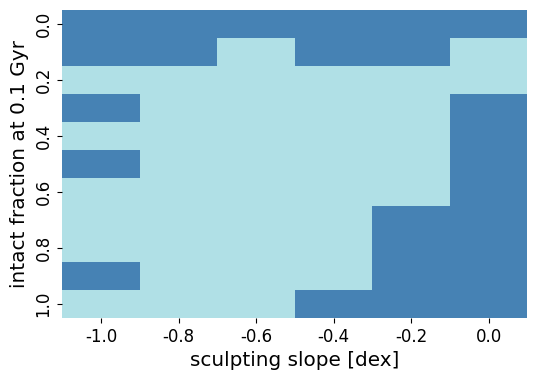

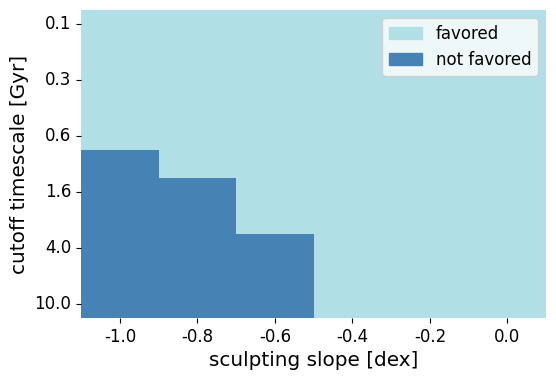

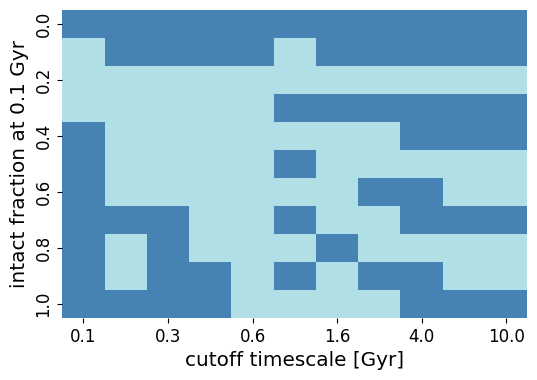

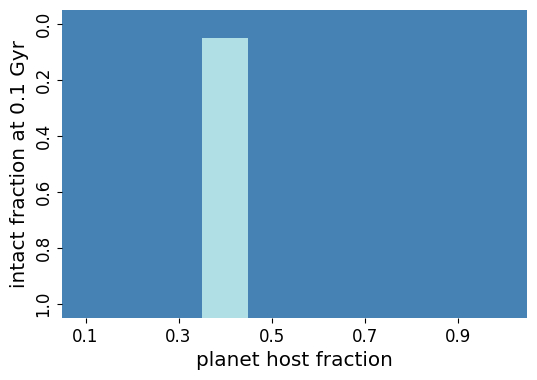

In [45]:
from matplotlib.colors import ListedColormap

f, ((ax1)) = plt.subplots(1, 1, figsize=(6, 4))

### 1
piv = recovery.groupby(['ms','bs']).max('logLs').reset_index()
piv.loc[piv.logLs >= best_logL - delta_logL,'logLs'] = 1
piv.loc[piv.logLs <  best_logL - delta_logL,'logLs'] = 0
piv = piv.pivot(index="bs",columns="ms",values="logLs") # vs logged_normalized_likelihood
    
sns.heatmap(piv, yticklabels=recovery.bs.unique().round(1), xticklabels=recovery.ms.unique().round(1), ax=ax1, 
            cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax1.set_yticks(ax1.get_yticks()[::2]) # sample every other tick, for cleanness
#ax1.set_title('m = -0.2, b = 1.0, c = 4e9, f = 0.3')
ax1.set(ylabel='intact fraction at 0.1 Gyr')
ax1.set(xlabel='sculpting slope [dex]')
plt.savefig(path+'figures/2d_a_asymmetric.png', facecolor='white', bbox_inches='tight')
plt.show()

### 2
f, ((ax2)) = plt.subplots(1, 1, figsize=(6, 4))
piv = recovery.groupby(['ms','cs']).max('logLs').reset_index()
piv.loc[piv.logLs >= best_logL - delta_logL,'logLs'] = 1
piv.loc[piv.logLs <  best_logL - delta_logL,'logLs'] = 0
piv = piv.pivot(index="cs",columns="ms",values="logLs") # vs logged_normalized_likelihood

sns.heatmap(piv, yticklabels=np.sort(np.round(recovery.cs.unique()/1e9,1)), xticklabels=recovery.ms.unique().round(1), 
            ax=ax2, cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax2.set_yticks(ax2.get_yticks()[::2]) # sample every other tick, for cleanness
ax2.set(ylabel='cutoff timescale [Gyr]')
ax2.set(xlabel='sculpting slope [dex]')

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

white_patch = mpatches.Patch(color='powderblue', label='favored')
black_patch = mpatches.Patch(color='steelblue', label='not favored')
ax2.legend(handles=[white_patch, black_patch], loc='upper right')
#plt.legend(handles=[white_patch, black_patch])
plt.savefig(path+'figures/2d_b_asymmetric.png', facecolor='white', bbox_inches='tight')
plt.show()

### 3
f, ((ax3)) = plt.subplots(1, 1, figsize=(6, 4))
piv = recovery.groupby(['cs','bs']).max('logLs').reset_index()
piv.loc[piv.logLs >= best_logL - delta_logL,'logLs'] = 1
piv.loc[piv.logLs <  best_logL - delta_logL,'logLs'] = 0
piv = piv.pivot(index="bs",columns="cs",values="logLs") # vs logged_normalized_likelihood

sns.heatmap(piv, xticklabels=np.sort(np.round(recovery.cs.unique()/1e9,1)), yticklabels=recovery.bs.unique().round(1), 
            ax=ax3, cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax3.set_yticks(ax3.get_yticks()[::2]) # sample every other tick, for cleanness
ax3.set(ylabel='intact fraction at 0.1 Gyr')
ax3.set(xlabel='cutoff timescale [Gyr]')
ax3.set_xticks(ax3.get_xticks()[::2]) # sample every other tick, for cleanness
plt.savefig(path+'figures/2d_c_asymmetric.png', facecolor='white', bbox_inches='tight')
plt.show()

### 4
f, ((ax4)) = plt.subplots(1, 1, figsize=(6, 4))
piv = recovery.groupby(['fs','bs']).max('logLs').reset_index()
piv.loc[piv.logLs >= best_logL - delta_logL,'logLs'] = 1
piv.loc[piv.logLs <  best_logL - delta_logL,'logLs'] = 0
piv = piv.pivot(index="bs",columns="fs",values="logLs") # vs logged_normalized_likelihood

sns.heatmap(piv, yticklabels=recovery.bs.unique().round(1), xticklabels=recovery.fs.unique().round(1), 
            ax=ax4, cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax4.set_yticks(ax4.get_yticks()[::2]) # sample every other tick, for cleanness
ax4.set_xticks(ax4.get_xticks()[::2]) # sample every other tick, for cleanness
ax4.set(ylabel='intact fraction at 0.1 Gyr')
ax4.set(xlabel='planet host fraction')

plt.savefig(path+'figures/2d_d_asymmetric.png', facecolor='white', bbox_inches='tight')
plt.show()


#### Does this picture look different for other planet disposition indicators?

koi_score

In [47]:
max(recovery.loc[recovery.logLs < 0.].logLs), max(recovery.loc[recovery.logLs_score < 0.].logLs_score)

(-14.514501940233815, -14.487834535224618)

In [37]:
best_logL = max(recovery.loc[recovery.logLs_score < 0.].logLs_score)
print(best_logL)
delta_logL = 10.

-14.487834535224618


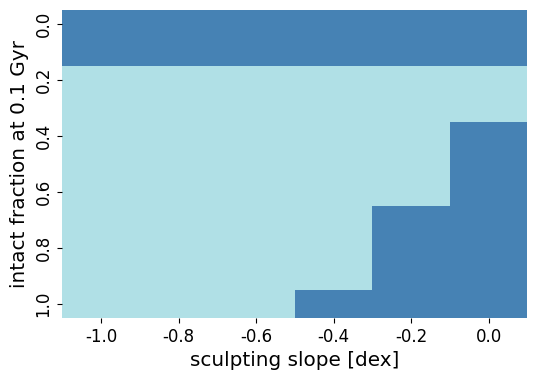

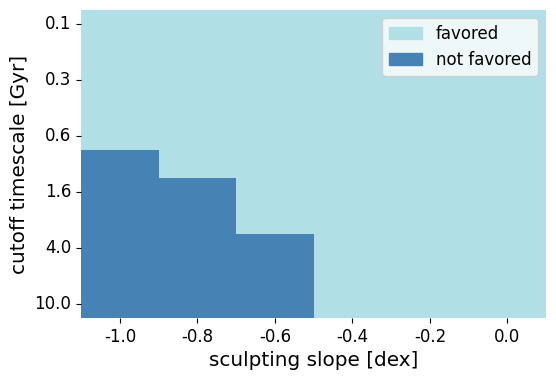

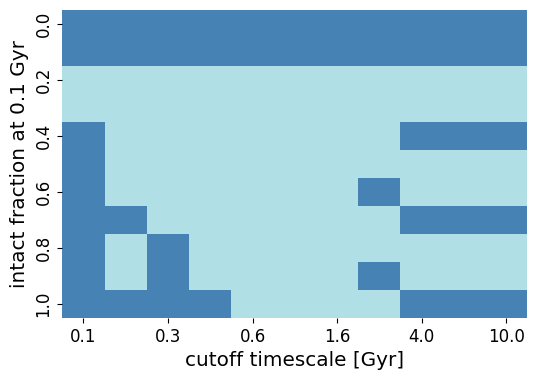

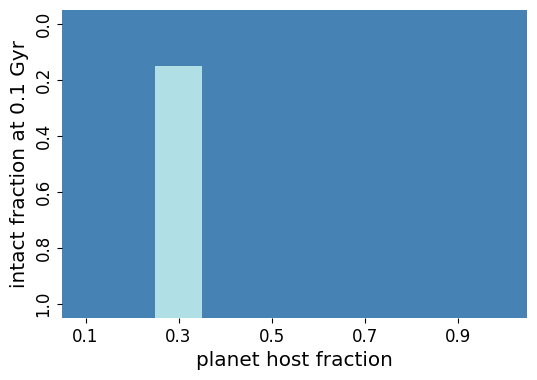

In [53]:
from matplotlib.colors import ListedColormap

f, ((ax1)) = plt.subplots(1, 1, figsize=(6, 4))

### 1
piv = recovery.groupby(['ms','bs']).max('logLs_score').reset_index()
piv.loc[piv.logLs_score >= best_logL - delta_logL,'logLs_score'] = 1
piv.loc[piv.logLs_score <  best_logL - delta_logL,'logLs_score'] = 0
piv = piv.pivot(index="bs",columns="ms",values="logLs_score") # vs logged_normalized_likelihood
    
sns.heatmap(piv, yticklabels=recovery.bs.unique().round(1), xticklabels=recovery.ms.unique().round(1), ax=ax1, 
            cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax1.set_yticks(ax1.get_yticks()[::2]) # sample every other tick, for cleanness
#ax1.set_title('m = -0.2, b = 1.0, c = 4e9, f = 0.3')
ax1.set(ylabel='intact fraction at 0.1 Gyr')
ax1.set(xlabel='sculpting slope [dex]')
plt.savefig(path+'figures/2d_a_asymmetric_score.png', facecolor='white', bbox_inches='tight')
plt.show()

### 2
f, ((ax2)) = plt.subplots(1, 1, figsize=(6, 4))
piv = recovery.groupby(['ms','cs']).max('logLs_score').reset_index()
piv.loc[piv.logLs_score >= best_logL - delta_logL,'logLs_score'] = 1
piv.loc[piv.logLs_score <  best_logL - delta_logL,'logLs_score'] = 0
piv = piv.pivot(index="cs",columns="ms",values="logLs_score") # vs logged_normalized_likelihood

sns.heatmap(piv, yticklabels=np.sort(np.round(recovery.cs.unique()/1e9,1)), xticklabels=recovery.ms.unique().round(1), 
            ax=ax2, cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax2.set_yticks(ax2.get_yticks()[::2]) # sample every other tick, for cleanness
ax2.set(ylabel='cutoff timescale [Gyr]')
ax2.set(xlabel='sculpting slope [dex]')

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

white_patch = mpatches.Patch(color='powderblue', label='favored')
black_patch = mpatches.Patch(color='steelblue', label='not favored')
ax2.legend(handles=[white_patch, black_patch], loc='upper right')
#plt.legend(handles=[white_patch, black_patch])
plt.savefig(path+'figures/2d_b_asymmetric_score.png', facecolor='white', bbox_inches='tight')
plt.show()

### 3
f, ((ax3)) = plt.subplots(1, 1, figsize=(6, 4))
piv = recovery.groupby(['cs','bs']).max('logLs_score').reset_index()
piv.loc[piv.logLs_score >= best_logL - delta_logL,'logLs_score'] = 1
piv.loc[piv.logLs_score <  best_logL - delta_logL,'logLs_score'] = 0
piv = piv.pivot(index="bs",columns="cs",values="logLs_score") # vs logged_normalized_likelihood

sns.heatmap(piv, xticklabels=np.sort(np.round(recovery.cs.unique()/1e9,1)), yticklabels=recovery.bs.unique().round(1), 
            ax=ax3, cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax3.set_yticks(ax3.get_yticks()[::2]) # sample every other tick, for cleanness
ax3.set(ylabel='intact fraction at 0.1 Gyr')
ax3.set(xlabel='cutoff timescale [Gyr]')
ax3.set_xticks(ax3.get_xticks()[::2]) # sample every other tick, for cleanness
plt.savefig(path+'figures/2d_c_asymmetric_score.png', facecolor='white', bbox_inches='tight')
plt.show()

### 4
f, ((ax4)) = plt.subplots(1, 1, figsize=(6, 4))
piv = recovery.groupby(['fs','bs']).max('logLs_score').reset_index()
piv.loc[piv.logLs_score >= best_logL - delta_logL,'logLs_score'] = 1
piv.loc[piv.logLs_score <  best_logL - delta_logL,'logLs_score'] = 0
piv = piv.pivot(index="bs",columns="fs",values="logLs_score") # vs logged_normalized_likelihood

sns.heatmap(piv, yticklabels=recovery.bs.unique().round(1), xticklabels=recovery.fs.unique().round(1), 
            ax=ax4, cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax4.set_yticks(ax4.get_yticks()[::2]) # sample every other tick, for cleanness
ax4.set_xticks(ax4.get_xticks()[::2]) # sample every other tick, for cleanness
ax4.set(ylabel='intact fraction at 0.1 Gyr')
ax4.set(xlabel='planet host fraction')
plt.savefig(path+'figures/2d_d_asymmetric_score.png', facecolor='white', bbox_inches='tight')
plt.show()


fpp_prob

In [48]:
best_logL = max(recovery.loc[recovery.logLs_fpp < 0.].logLs_fpp)
print(best_logL)
delta_logL = 10.

-14.302663070532752


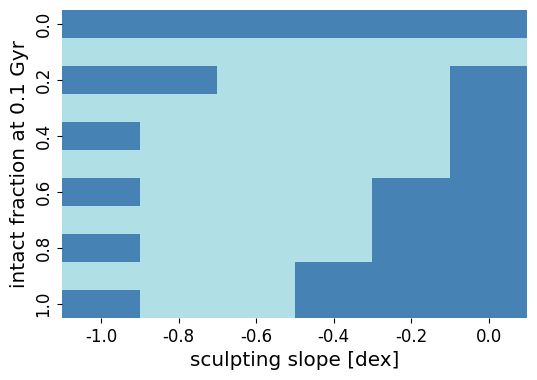

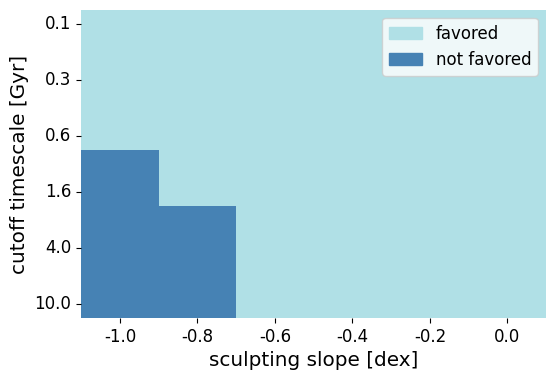

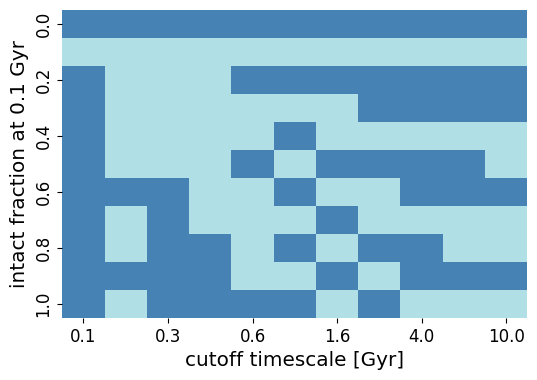

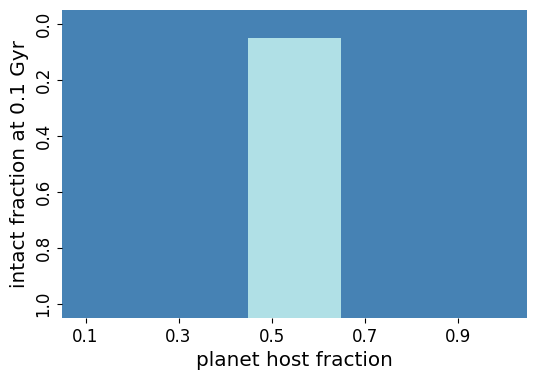

In [54]:
from matplotlib.colors import ListedColormap

f, ((ax1)) = plt.subplots(1, 1, figsize=(6, 4))

### 1
piv = recovery.groupby(['ms','bs']).max('logLs_fpp').reset_index()
piv.loc[piv.logLs_fpp >= best_logL - delta_logL,'logLs_fpp'] = 1
piv.loc[piv.logLs_fpp <  best_logL - delta_logL,'logLs_fpp'] = 0
piv = piv.pivot(index="bs",columns="ms",values="logLs_fpp") # vs logged_normalized_likelihood
    
sns.heatmap(piv, yticklabels=recovery.bs.unique().round(1), xticklabels=recovery.ms.unique().round(1), ax=ax1, 
            cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax1.set_yticks(ax1.get_yticks()[::2]) # sample every other tick, for cleanness
#ax1.set_title('m = -0.2, b = 1.0, c = 4e9, f = 0.3')
ax1.set(ylabel='intact fraction at 0.1 Gyr')
ax1.set(xlabel='sculpting slope [dex]')
plt.savefig(path+'figures/2d_a_asymmetric_fpp.png', facecolor='white', bbox_inches='tight')
plt.show()

### 2
f, ((ax2)) = plt.subplots(1, 1, figsize=(6, 4))
piv = recovery.groupby(['ms','cs']).max('logLs_fpp').reset_index()
piv.loc[piv.logLs_fpp >= best_logL - delta_logL,'logLs_fpp'] = 1
piv.loc[piv.logLs_fpp <  best_logL - delta_logL,'logLs_fpp'] = 0
piv = piv.pivot(index="cs",columns="ms",values="logLs_fpp") # vs logged_normalized_likelihood

sns.heatmap(piv, yticklabels=np.sort(np.round(recovery.cs.unique()/1e9,1)), xticklabels=recovery.ms.unique().round(1), 
            ax=ax2, cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax2.set_yticks(ax2.get_yticks()[::2]) # sample every other tick, for cleanness
ax2.set(ylabel='cutoff timescale [Gyr]')
ax2.set(xlabel='sculpting slope [dex]')

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

white_patch = mpatches.Patch(color='powderblue', label='favored')
black_patch = mpatches.Patch(color='steelblue', label='not favored')
ax2.legend(handles=[white_patch, black_patch], loc='upper right')
#plt.legend(handles=[white_patch, black_patch])
plt.savefig(path+'figures/2d_b_asymmetric_fpp.png', facecolor='white', bbox_inches='tight')
plt.show()

### 3
f, ((ax3)) = plt.subplots(1, 1, figsize=(6, 4))
piv = recovery.groupby(['cs','bs']).max('logLs_fpp').reset_index()
piv.loc[piv.logLs_fpp >= best_logL - delta_logL,'logLs_fpp'] = 1
piv.loc[piv.logLs_fpp <  best_logL - delta_logL,'logLs_fpp'] = 0
piv = piv.pivot(index="bs",columns="cs",values="logLs_fpp") # vs logged_normalized_likelihood

sns.heatmap(piv, xticklabels=np.sort(np.round(recovery.cs.unique()/1e9,1)), yticklabels=recovery.bs.unique().round(1), 
            ax=ax3, cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax3.set_yticks(ax3.get_yticks()[::2]) # sample every other tick, for cleanness
ax3.set(ylabel='intact fraction at 0.1 Gyr')
ax3.set(xlabel='cutoff timescale [Gyr]')
ax3.set_xticks(ax3.get_xticks()[::2]) # sample every other tick, for cleanness
plt.savefig(path+'figures/2d_c_asymmetric_fpp.png', facecolor='white', bbox_inches='tight')
plt.show()

### 4
f, ((ax4)) = plt.subplots(1, 1, figsize=(6, 4))
piv = recovery.groupby(['fs','bs']).max('logLs_fpp').reset_index()
piv.loc[piv.logLs_fpp >= best_logL - delta_logL,'logLs_fpp'] = 1
piv.loc[piv.logLs_fpp <  best_logL - delta_logL,'logLs_fpp'] = 0
piv = piv.pivot(index="bs",columns="fs",values="logLs_fpp") # vs logged_normalized_likelihood

sns.heatmap(piv, yticklabels=recovery.bs.unique().round(1), xticklabels=recovery.fs.unique().round(1), 
            ax=ax4, cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax4.set_yticks(ax4.get_yticks()[::2]) # sample every other tick, for cleanness
ax4.set_xticks(ax4.get_xticks()[::2]) # sample every other tick, for cleanness
ax4.set(ylabel='intact fraction at 0.1 Gyr')
ax4.set(xlabel='planet host fraction')
plt.savefig(path+'figures/2d_d_asymmetric_fpp.png', facecolor='white', bbox_inches='tight')
plt.show()


#### Plot transit multiplicities of favored models, for all 3 KOI indicators

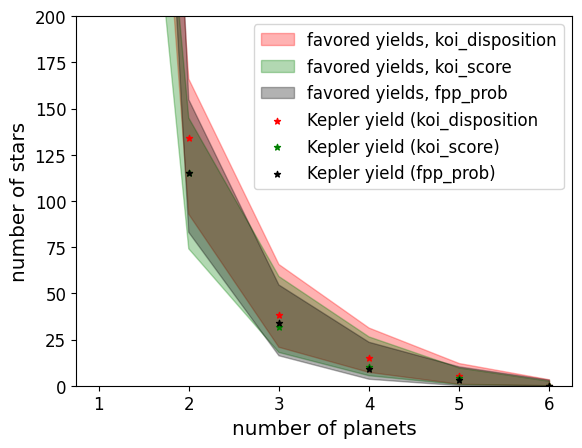

In [80]:
from itertools import zip_longest
import numpy.ma as ma # for masked arrays

yield_max = []
yield_min = []
for temp_list in zip_longest(*good_models.transit_multiplicities):
    yield_max.append(np.max(temp_list))
    yield_min.append(np.min(temp_list))

yield_max_score = []
yield_min_score = []
for temp_list in zip_longest(*good_models_score.transit_multiplicities):
    yield_max_score.append(np.max(temp_list))
    yield_min_score.append(np.min(temp_list))

yield_max_fpp = []
yield_min_fpp = []
for temp_list in zip_longest(*good_models_fpp.transit_multiplicities):
    yield_max_fpp.append(np.max(temp_list))
    yield_min_fpp.append(np.min(temp_list))

plt.fill_between(np.arange(7)[1:], yield_max, yield_min, color='r', alpha=0.3, label='favored yields (koi_disposition)') # 03acb1
plt.fill_between(np.arange(7)[1:], yield_max_score, yield_min_score, color='g', alpha=0.3, label='favored yields (koi_score)')
plt.fill_between(np.arange(7)[1:], yield_max_fpp, yield_min_fpp, color='k', alpha=0.3, label='favored yields (fpp_prob)')

plt.scatter(np.arange(7)[1:], k, color='r', marker='*', s=20, label='Kepler yield (koi_disposition)')
plt.scatter(np.arange(7)[1:], k_score, color='g', marker='*', s=20, label='Kepler yield (koi_score)')
plt.scatter(np.arange(7)[1:], k_fpp, color='k', marker='*', s=20, label='Kepler yield (fpp_prob)')

plt.xlabel('number of planets')
plt.ylabel('number of stars')
plt.legend()
plt.ylim([0, 200])
#plt.savefig(path+'figures/good-yields.png', facecolor='white', bbox_inches='tight')
plt.show()

In [73]:
print(np.mean(good_models.intact_fracs), 
np.mean(good_models_score.intact_fracs), 
np.mean(good_models_fpp.intact_fracs))

0.07786551946451321 0.06665159495034428 0.05332472977046908


In [87]:
print(list(np.array(k)))
print(list(np.array(k_score)))
print(list(np.array(k_fpp)))

[833, 134, 38, 15, 5, 0]
[631, 115, 32, 10, 4, 0]
[1088, 115, 34, 9, 3, 0]


The zoomed-in plot explains why koi_disposition's favored intact fractions are highest despite having a 1-bin well under that of koi_score. I think koi_score just has fewer planets across the board, resulting in a multiplicity slope that is not actually less sleep than that of koi_disposition. The green star is under the black star in the 2-bin, since koi_score and fpp_prob have the exact same number of 2-planet systems.

### Old stuff

In [27]:
np.linspace(0.1, 1, 10), marginalized_logLs

f_vs_logL_df = pd.DataFrame({'fs': fs, 'logLs': marginalized_logLs})
print(f_vs_logL_df.loc[f_vs_logL_df.logLs==max(marginalized_logLs)])
print(f_vs_logL_df.logLs.quantile(0.32))
print(f_vs_logL_df.loc[f_vs_logL_df.logLs>=f_vs_logL_df.logLs.quantile(0.32)])
print(f_vs_logL_df.loc[f_vs_logL_df.logLs>=f_vs_logL_df.logLs.quantile(0.32)].logLs.max())

    fs      logLs
4  0.5 -194.45517
-389.79948286991277
    fs       logLs
1  0.2 -307.435717
2  0.3 -201.126324
3  0.4 -195.327725
4  0.5 -194.455170
5  0.6 -230.531695
6  0.7 -294.103880
7  0.8 -377.858955
-194.4551697693005


Unlike in the injection-recovery tests, the real ground truth appears to weakly favor long-lived sculpting at fast to moderate speeds and initial intact fractions of less than 0.6. Perhaps the 2D posteriors will shed more light.

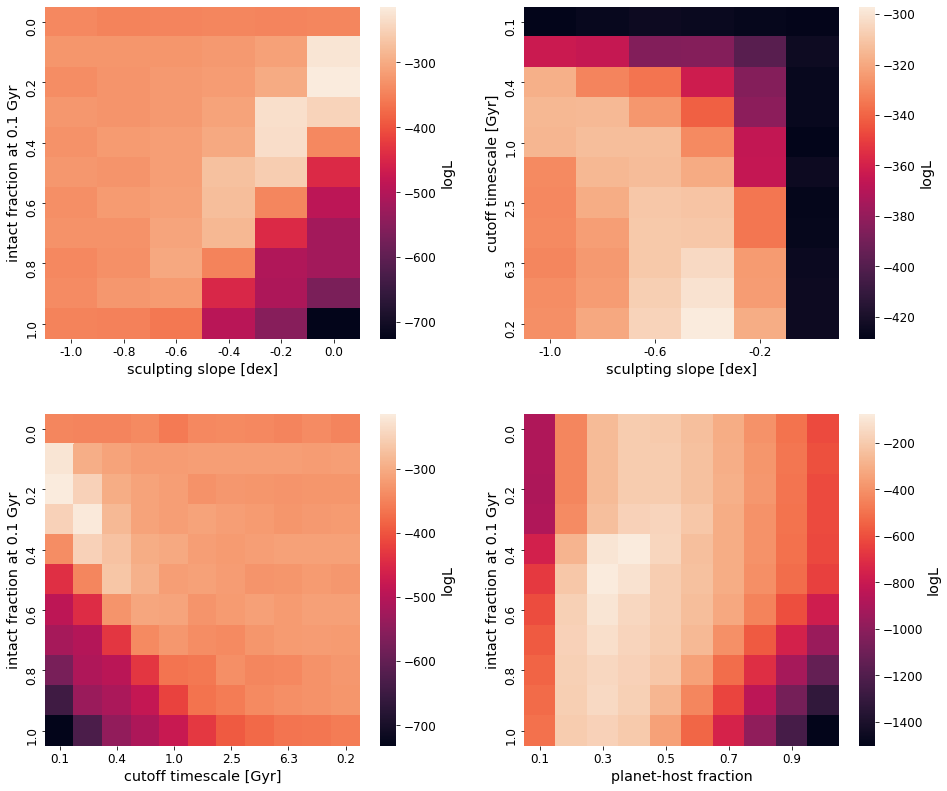

In [184]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 12))
f.tight_layout(pad=5.)

### 1
piv = recovery.groupby(['ms','bs']).median('logLs').reset_index()
piv = piv.pivot("bs","ms","logLs") # vs logged_normalized_likelihood

sns.heatmap(piv, yticklabels=recovery.bs.unique().round(1), xticklabels=recovery.ms.unique().round(1), 
            cbar_kws={'label': 'logL'}, ax=ax1)
ax1.set_yticks(ax1.get_yticks()[::2]) # sample every other tick, for cleanness
ax1.set(ylabel='intact fraction at 0.1 Gyr')
ax1.set(xlabel='sculpting slope [dex]')

### 2
piv = recovery.groupby(['ms','cs']).median('logLs').reset_index()
piv = piv.pivot("cs","ms","logLs") # vs logged_normalized_likelihood

sns.heatmap(piv, yticklabels=np.round(recovery.cs.unique()/1e9,1), xticklabels=recovery.ms.unique().round(1), 
            cbar_kws={'label': 'logL'}, ax=ax2)
ax2.set_yticks(ax2.get_yticks()[::2]) # sample every other tick, for cleanness
ax2.set_xticks(ax2.get_xticks()[::2]) # sample every other tick, for cleanness
ax2.set(ylabel='cutoff timescale [Gyr]')
ax2.set(xlabel='sculpting slope [dex]')
#ax2.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#ax2.yaxis.set_major_formatter(tick.FormatStrFormatter('%2.2e'))

### 3
piv = recovery.groupby(['cs','bs']).median('logLs').reset_index()
piv = piv.pivot("bs","cs","logLs") # vs logged_normalized_likelihood

sns.heatmap(piv, yticklabels=np.round(recovery.bs.unique(),1), xticklabels=np.round(recovery.cs.unique()/1e9,1), 
            cbar_kws={'label': 'logL'}, ax=ax3)
ax3.set_yticks(ax3.get_yticks()[::2]) # sample every other tick, for cleanness
ax3.set_xticks(ax3.get_xticks()[::2]) # sample every other tick, for cleanness
ax3.set(xlabel='cutoff timescale [Gyr]')
ax3.set(ylabel='intact fraction at 0.1 Gyr')
#ax2.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#ax2.yaxis.set_major_formatter(tick.FormatStrFormatter('%2.2e'))


### 4
piv = recovery.groupby(['fs','bs']).median('logLs').reset_index()
piv = piv.pivot("bs","fs","logLs") # vs logged_normalized_likelihood

sns.heatmap(piv, yticklabels=np.round(recovery.bs.unique(),1), xticklabels=np.round(recovery.fs.unique(),1), 
            cbar_kws={'label': 'logL'}, ax=ax4)
ax4.set_yticks(ax4.get_yticks()[::2]) # sample every other tick, for cleanness
ax4.set_xticks(ax4.get_xticks()[::2]) # sample every other tick, for cleanness
ax4.set(xlabel='planet-host fraction')
ax4.set(ylabel='intact fraction at 0.1 Gyr')
#ax2.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#ax2.yaxis.set_major_formatter(tick.FormatStrFormatter('%2.2e'))

plt.savefig(path+'figures/2d-posteriors.png', facecolor='white', bbox_inches='tight')
plt.show()

These 2D posteriors show that the most favored combination of b and c are "short-lived" dynamical sculpting of systems that are already carved up into disrupted systems by 0.1 Gyr (third subplot). At the same time, we find as well that a moderate sculpting law slope of -0.4 for 10 Gyr is favored (second subplot). These two scenarios underpin a strip of favored models that runs diagonally from moderate sculpting off of a moderate initial intact fraction, to no sculpting off of an initially low intact fraction (first subplot). 

Now, all models are not built the same because 1) as evidenced by the uniformly shaded column for no sculpting as a function of cutoff time, some models are nonsensical (eg. models whose cutoffs come after the first half of the piecewise function already decays to zero; varying cutoff times for non-sculpting models). Also, 2) the age distributino of our stellar sample is such that different amounts of the sample are affected by different models. For example, a model with cutoff time at 1 Gyr is going to be a functional no-sculpting model for most stars. 

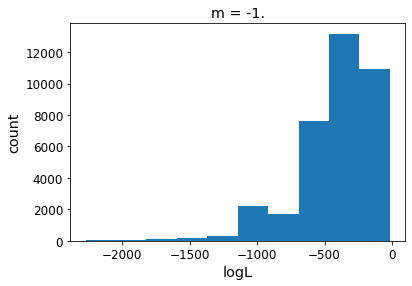

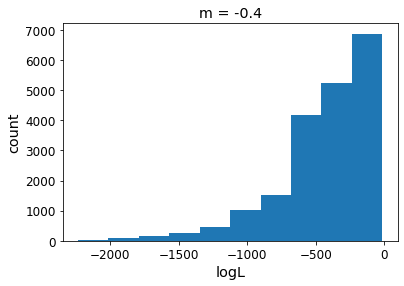

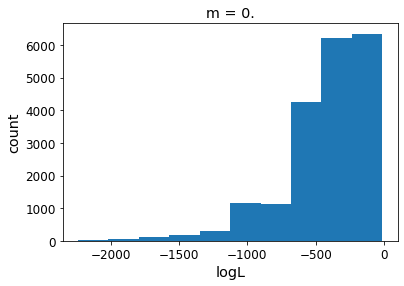

In [185]:
#print(recovery.loc[(recovery.cs == np.round(np.sort(recovery.cs.unique())[0], 0))].head())
plt.hist(recovery.loc[(recovery.ms == np.round(np.sort(recovery.ms.unique())[0], 0))].logLs)
#plt.title('c = 1e8 yrs')
plt.title('m = -1.')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()

#print(recovery.loc[(np.round(recovery.cs,0) == np.round(np.sort(recovery.cs.unique())[1], 0))].head())
plt.hist(recovery.loc[(np.round(recovery.cs,0) == np.round(np.sort(recovery.cs.unique())[3], 0))].logLs)
#plt.title('c = 158489319 yrs')
plt.title('m = -0.4')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()

#print(recovery.loc[(np.round(recovery.cs,0) == np.round(np.sort(recovery.cs.unique())[2], 0))].head())
plt.hist(recovery.loc[(np.round(recovery.cs,0) == np.round(np.sort(recovery.cs.unique())[5], 0))].logLs)
#plt.title('c = 251188643 yrs')
plt.title('m = 0.')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()


In [33]:
"""
# calculate delta_logL
spreads = []
for gi_m in np.sort(recovery.ms.unique()):
    for gi_b in np.sort(recovery.bs.unique()):
        for gi_c in np.sort(recovery.cs.unique()):
            for f in np.round(np.linspace(0.1, 1, 10),1):
                models = recovery.loc[(np.round(recovery.ms,1)==np.round(gi_m,1))&(np.round(recovery.bs,1)==np.round(gi_b,1))&(np.round(recovery.cs,0)==np.round(gi_c,0))&(np.round(recovery.fs,1)==f)]
                spreads.append(np.std(models.logLs)) 
                
"""

In [26]:
best_logL = max(recovery.loc[recovery.logLs < 0.].logLs)
print("Best model: ", recovery.loc[recovery.logLs == best_logL])

# delta logL is the median spread of logLs across all models
#delta_logL = np.median(spreads)
delta_logL = 10.

good_models = recovery.loc[np.abs(recovery.logLs - best_logL) <= delta_logL]
print("Some models between best model and ground truth: ")
print(good_models)

Best model:           ms   bs            cs   fs  \
150692 -0.4  0.8  6.309573e+09  0.4   

                                   transit_multiplicities  \
150692  [831.2, 135.6, 38.800000000000004, 15.60000000...   

                    geom_transit_multiplicities  intact_fracs  \
150692  [1585.2, 273.6, 113.2, 55.6, 35.2, 6.0]      0.069031   

        disrupted_fracs      logLs  
150692         0.330969 -14.528591  
Some models between best model and ground truth: 
        ms   bs            cs   fs  \
3716  -1.0  0.1  1.000000e+08  0.4   
7290  -1.0  0.2  1.000000e+08  0.4   
7291  -1.0  0.2  1.000000e+08  0.4   
7292  -1.0  0.2  1.000000e+08  0.4   
7293  -1.0  0.2  1.000000e+08  0.4   
...    ...  ...           ...  ...   
17215  0.0  0.2  1.584893e+08  0.4   
17216  0.0  0.2  1.584893e+08  0.4   
17217  0.0  0.2  1.584893e+08  0.4   
17218  0.0  0.2  1.584893e+08  0.4   
17219  0.0  0.2  1.584893e+08  0.4   

                                  transit_multiplicities  \
3716   [827.6

Plot good models, where "good" is defined as being within a typical logL spread of the best-logL model. 

In [27]:
def build_models(x, m, b, c, f): # adapted from Ballard et al in prep, log version
    """ 
    Calculate P(intact) as a function of time, in order to visualize sculpting models.

    Input:
    - x: grid of ages [log yrs]
    - m: sculpting law slope [dex]
    - b: sculpting law initial intact probability, out of planet-hosting stars
    - c: sculpting law turnoff time [log yrs]
    - f: fraction of planet-hosting stars

    Output:
    - y: grid of P(intacts)

    """

    # x-axis before cutoff
    x1 = x[x<c]
    x2 = x[x>=c]
    
    # first piece, before cutoff
    y1 = (b + m * (np.log10(x1) - 8)) * f
    
    # second piece, after cutoff
    y2 = np.ones(len(x2)) * (b + m * (np.log10(c) - 8)) * f
    
    y = np.concatenate((y1, y2))
    
    # flatten out at zero
    y = np.where(y < 0, 0, y)
    
    return y

In [28]:
def calculate_present_day_intact(x, m, b, c, f):
    
    if x < c:
        # first piece, before cutoff
        y = (b + m * (np.log10(x) - 8)) * f
    
    elif x >= c:
        y = (b + m * (np.log10(c) - 8)) * f
    
    return y

#calculate_present_day_intact(4e9, m, b, c, f)

-0.8 0.6000000000000001 251188643.1509582 0.4
-0.8 0.9 630957344.4801943 0.4
-0.6 0.5 251188643.1509582 0.4
-0.3999999999999999 0.5 398107170.5534969 0.4
-0.1999999999999999 0.5 1584893192.4611108 0.4
-0.6 0.4 158489319.2461111 0.4
-0.1999999999999999 0.3 158489319.2461111 0.4
0.016000000000000104 0.1120000000000002


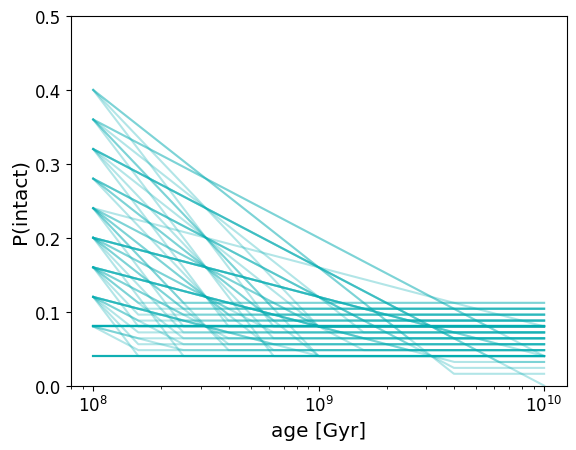

In [30]:
x = np.logspace(8, 10, 1000)

### best model
#best_model = model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)]
#m, b, c, f = best_model.m.to_list()[0], best_model.b.to_list()[0], best_model.c.to_list()[0], best_model.f.to_list()[0]
#plt.plot(x, build_models(x, m, b, c, f), label='best fit', color='k')

### models as good as or better than ground truth
good_models_deduped = good_models.drop_duplicates(subset=['ms','bs','cs','fs'])
label_flag = True
present_day_intacts = []
delta_p_intacts = []

for index, row in good_models_deduped.reset_index().iterrows(): 
    m, b, c, f = row.ms, row.bs, row.cs, row.fs
    if label_flag == True:
        plt.plot(x, build_models(x, m, b, c, f), color='#03acb1', zorder=0, label='favored models', alpha=0.3)
    elif label_flag == False:
        plt.plot(x, build_models(x, m, b, c, f), color='#03acb1', zorder=0, alpha=0.3)
    label_flag = False  
    
    if build_models(x, m, b, c, f)[-1] > 0.1:
        print(m, b, c, f)
    
    present_day_intacts.append(calculate_present_day_intact(4e9, m, b, c, f))
    
    delta_p_intact = calculate_present_day_intact(1e8, m, b, c, f) - calculate_present_day_intact(1e10, m, b, c, f)
    delta_p_intacts.append(delta_p_intact)
    
print(np.min(present_day_intacts), np.max(present_day_intacts))

#plt.vlines(4e9, 0, 0.5, linestyle='--', color='r', label='4 Gyrs')
plt.xscale('log')
plt.ylim([0, 0.5])
plt.xlabel('age [Gyr]')
plt.ylabel('P(intact)')
#plt.legend()
#plt.savefig(path+'plots/good-models.png', facecolor='white', bbox_inches='tight')

plt.show()

What are the favored models with the greatest $\Delta$P(intact)?

In [327]:
print(np.argmin(delta_p_intacts), np.argmax(delta_p_intacts))
print(np.min(delta_p_intacts), np.max(delta_p_intacts))


0 27
0.0 0.3839999999999999


In [325]:
print(good_models_deduped.iloc[np.argmin(delta_p_intacts)]) # 0, 1, 0, 0.4
print(good_models_deduped.iloc[np.argmax(delta_p_intacts)]) # 2, 10, 7, 0.4

ms                                                                            -1
bs                                                                           0.1
cs                                                                         1e+08
fs                                                                           0.4
transit_multiplicities         [827.6, 99.60000000000001, 27.6, 9.20000000000...
geom_transit_multiplicities    [1604.8000000000002, 219.20000000000002, 50.40...
intact_fracs                                                            0.115244
disrupted_fracs                                                         0.284756
logLs                                                                    -24.135
Name: 3716, dtype: object
ms                                                                          -0.6
bs                                                                             1
cs                                                                   3.98107e+09
fs

The favored intact fraction among stars of the same age as the Sun is 2-11%.

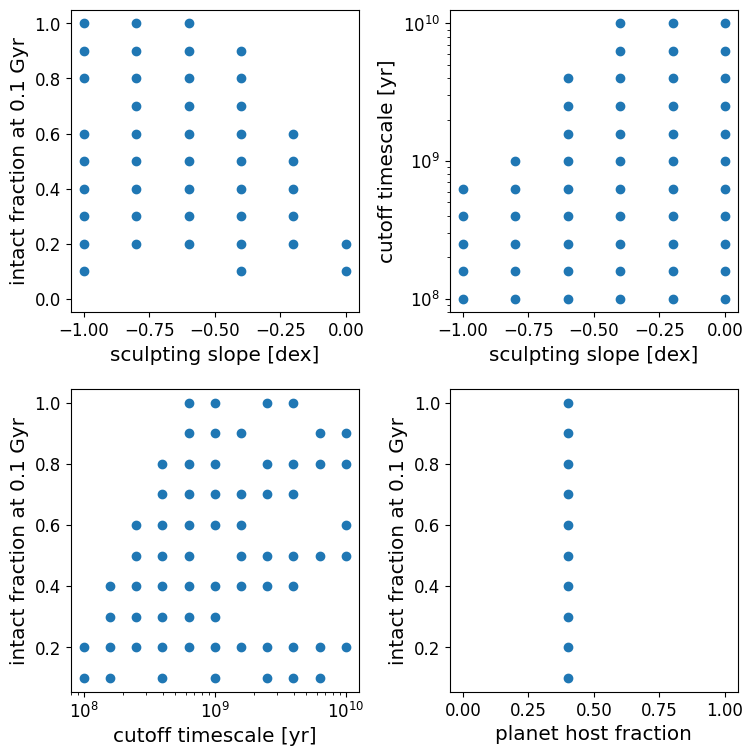

In [32]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))
f.tight_layout(pad=3.)

good_models_m_b = good_models.drop_duplicates(subset=['ms','bs'])
ax1.scatter(good_models_m_b.ms, good_models_m_b.bs)
ax1.set_xlabel('sculpting slope [dex]')
ax1.set_ylabel('intact fraction at 0.1 Gyr')
ax1.set_xlim([-1.05, 0.05])
ax1.set_ylim([-0.05, 1.05])

good_models_m_c = good_models.drop_duplicates(subset=['ms','cs'])
ax2.scatter(good_models_m_c.ms, good_models_m_c.cs)
ax2.set_xlabel('sculpting slope [dex]')
ax2.set_ylabel('cutoff timescale [yr]')
ax2.set_xlim([-1.05, 0.05])
ax2.set_yscale('log')

good_models_c_b = good_models.drop_duplicates(subset=['cs','bs'])
ax3.scatter(good_models_c_b.cs, good_models_c_b.bs)
ax3.set_xlabel('cutoff timescale [yr]')
ax3.set_ylabel('intact fraction at 0.1 Gyr')
#ax3.set_xlim([-1.05, 0.05])
ax3.set_xscale('log')

good_models_f_b = good_models.drop_duplicates(subset=['fs','bs'])
ax4.scatter(good_models_f_b.fs, good_models_f_b.bs)
ax4.set_xlabel('planet host fraction')
ax4.set_ylabel('intact fraction at 0.1 Gyr')
ax4.set_xlim([-0.05, 1.05])

#plt.savefig(path+'figures/good-models-2d.png', facecolor='white', bbox_inches='tight')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/chrislam/Desktop/mastrangelo/figures/2d_a.png'

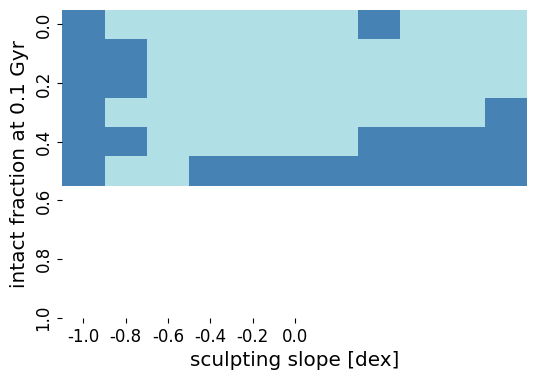

In [34]:
from matplotlib.colors import ListedColormap

f, ((ax1)) = plt.subplots(1, 1, figsize=(6, 4))

### 1
piv = recovery.groupby(['ms','bs']).max('logLs').reset_index()
piv.loc[piv.logLs >= best_logL - delta_logL,'logLs'] = 1
piv.loc[piv.logLs <  best_logL - delta_logL,'logLs'] = 0
piv = piv.pivot(columns="bs",index="ms",values="logLs") # vs logged_normalized_likelihood
    
sns.heatmap(piv, yticklabels=recovery.bs.unique().round(1), xticklabels=recovery.ms.unique().round(1), ax=ax1, 
            cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax1.set_yticks(ax1.get_yticks()[::2]) # sample every other tick, for cleanness
#ax1.set_title('m = -0.2, b = 1.0, c = 4e9, f = 0.3')
ax1.set(ylabel='intact fraction at 0.1 Gyr')
ax1.set(xlabel='sculpting slope [dex]')
plt.savefig(path+'figures/2d_a.png', facecolor='white', bbox_inches='tight')
plt.show()

### 2
f, ((ax2)) = plt.subplots(1, 1, figsize=(6, 4))
piv = recovery.groupby(['ms','cs']).max('logLs').reset_index()
piv.loc[piv.logLs >= best_logL - delta_logL,'logLs'] = 1
piv.loc[piv.logLs <  best_logL - delta_logL,'logLs'] = 0
piv = piv.pivot("cs","ms","logLs") # vs logged_normalized_likelihood

sns.heatmap(piv, yticklabels=np.sort(np.round(recovery.cs.unique()/1e9,1)), xticklabels=recovery.ms.unique().round(1), 
            ax=ax2, cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax2.set_yticks(ax2.get_yticks()[::2]) # sample every other tick, for cleanness
ax2.set(ylabel='cutoff timescale [Gyr]')
ax2.set(xlabel='sculpting slope [dex]')

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

white_patch = mpatches.Patch(color='powderblue', label='favored')
black_patch = mpatches.Patch(color='steelblue', label='not favored')
ax2.legend(handles=[white_patch, black_patch], loc='upper right')
#plt.legend(handles=[white_patch, black_patch])
plt.savefig(path+'figures/2d_b.png', facecolor='white', bbox_inches='tight')
plt.show()

### 3
f, ((ax3)) = plt.subplots(1, 1, figsize=(6, 4))
piv = recovery.groupby(['cs','bs']).max('logLs').reset_index()
piv.loc[piv.logLs >= best_logL - delta_logL,'logLs'] = 1
piv.loc[piv.logLs <  best_logL - delta_logL,'logLs'] = 0
piv = piv.pivot("bs","cs","logLs") # vs logged_normalized_likelihood

sns.heatmap(piv, xticklabels=np.sort(np.round(recovery.cs.unique()/1e9,1)), yticklabels=recovery.bs.unique().round(1), 
            ax=ax3, cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax3.set_yticks(ax3.get_yticks()[::2]) # sample every other tick, for cleanness
ax3.set(ylabel='intact fraction at 0.1 Gyr')
ax3.set(xlabel='cutoff timescale [Gyr]')
ax3.set_xticks(ax3.get_xticks()[::2]) # sample every other tick, for cleanness
plt.savefig(path+'figures/2d_c.png', facecolor='white', bbox_inches='tight')
plt.show()

### 4
f, ((ax4)) = plt.subplots(1, 1, figsize=(6, 4))
piv = recovery.groupby(['fs','bs']).max('logLs').reset_index()
piv.loc[piv.logLs >= best_logL - delta_logL,'logLs'] = 1
piv.loc[piv.logLs <  best_logL - delta_logL,'logLs'] = 0
piv = piv.pivot("bs","fs","logLs") # vs logged_normalized_likelihood

sns.heatmap(piv, yticklabels=recovery.bs.unique().round(1), xticklabels=recovery.fs.unique().round(1), 
            ax=ax4, cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax4.set_yticks(ax4.get_yticks()[::2]) # sample every other tick, for cleanness
ax4.set_xticks(ax4.get_xticks()[::2]) # sample every other tick, for cleanness
ax4.set(ylabel='intact fraction at 0.1 Gyr')
ax4.set(xlabel='planet host fraction')

#plt.savefig(path+'figures/2d_d.png', facecolor='white', bbox_inches='tight')
plt.show()

Let's plot these model yields, compared to the real ground truth transit yield.

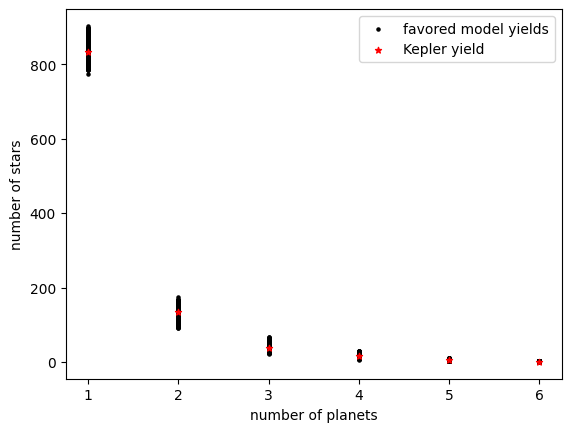

In [42]:
#good_weird1 = recovery.loc[(np.round(recovery.ms,1) == -0.4) & (np.round(recovery.bs,1) == 0.8) & (np.round(recovery.cs, -7) == 1.6e8) & (np.round(recovery.fs,1) == 0.4)]
#good_weird2 = recovery.loc[(np.round(recovery.ms,1) == -0.4) & (np.round(recovery.bs,1) == 0.9) & (np.round(recovery.cs, -7) == 1.6e8) & (np.round(recovery.fs,1) == 0.4)]
#good_weird3 = recovery.loc[(np.round(recovery.ms,1) == -0.2) & (np.round(recovery.bs,1) == 0.5) & (np.round(recovery.cs, -7) == 1.6e8) & (np.round(recovery.fs,1) == 0.4)]
#print(len(good_weird1), len(good_weird2), len(good_weird3))

k = pd.Series([833, 134, 38, 15, 5, 0])
k_score = pd.Series([631, 115, 32, 10, 4, 0])
k_fpp = pd.Series([1088, 115, 34, 9, 3, 0])

#plt.scatter(np.arange(7)[1:], good_weird3.iloc[0].transit_multiplicities, color='k', s=5, label='-0.2, 0.5, 1.6e8')
plt.scatter(np.arange(7)[1:], good_models.iloc[0].transit_multiplicities, color='k', s=5, label='favored model yields')

for i in range(len(good_models.iloc[1:])):
    row = good_models.iloc[i]
    plt.scatter(np.arange(7)[1:], row.transit_multiplicities, color='k', s=5)
    #print(better_loglike(good_weird1.iloc[i].transit_multiplicities, k))
    
plt.scatter(np.arange(7)[1:], k, color='r', marker='*', s=20, label='Kepler yield')
plt.xlabel('number of planets')
plt.ylabel('number of stars')
plt.legend()
#plt.savefig(path+'figures/good-yields.png', facecolor='white', bbox_inches='tight')
plt.show()

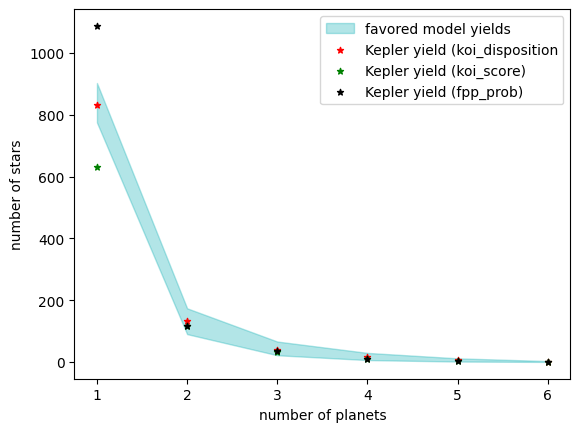

In [43]:
from itertools import zip_longest
import numpy.ma as ma # for masked arrays

yield_max = []
yield_min = []
for temp_list in zip_longest(*good_models.transit_multiplicities):
    yield_max.append(np.max(temp_list))
    yield_min.append(np.min(temp_list))
    
plt.fill_between(np.arange(7)[1:], yield_max, yield_min, color='#03acb1', alpha=0.3, label='favored model yields')
plt.scatter(np.arange(7)[1:], k, color='r', marker='*', s=20, label='Kepler yield (koi_disposition')
plt.scatter(np.arange(7)[1:], k_score, color='g', marker='*', s=20, label='Kepler yield (koi_score)')
plt.scatter(np.arange(7)[1:], k_fpp, color='k', marker='*', s=20, label='Kepler yield (fpp_prob)')
plt.xlabel('number of planets')
plt.ylabel('number of stars')
plt.legend()
#plt.savefig(path+'figures/good-yields.png', facecolor='white', bbox_inches='tight')
plt.show()

In [134]:
len(good_models_deduped)/(6*11*11*10)

0.008953168044077135

So <1% of models are "good" models

Now let's plot the other two key plots involved in the paper: intact fraction as a function of logL, and the f_hot vs f_cold heatmap.

First, we need to find out what the 68th percentile intact fraction is, to give an upper bound on the present-day intact fraction among Kepler-like stars. Note that this is the intact fraction over all stars, not just planet hosts. 

In [105]:
intact_v_logL_df = pd.DataFrame({'intact_fracs': median_intact_fracs, 'logLs': median_logLs})
print(intact_v_logL_df.loc[intact_v_logL_df.logLs==max(median_logLs)])
print(median_logLs.quantile(0.32))
print(intact_v_logL_df.loc[intact_v_logL_df.logLs>=median_logLs.quantile(0.32)])
print(intact_v_logL_df.loc[intact_v_logL_df.logLs>=median_logLs.quantile(0.32)].intact_fracs.max())

                          intact_fracs      logLs
ms   bs  cs          fs                          
-0.6 0.2 100000000.0 0.4       0.19121 -16.618432
-495.4910171533474
                           intact_fracs       logLs
ms   bs  cs           fs                           
-1.0 0.0 1.000000e+08 0.2           0.0 -436.366669
                      0.3           0.0 -258.598361
                      0.4           0.0 -194.257482
                      0.5           0.0 -195.861216
                      0.6           0.0 -233.706419
...                                 ...         ...
 0.0 1.0 6.309573e+09 0.4           0.4 -386.416475
         1.000000e+10 0.1           0.1 -463.646347
                      0.2           0.2 -201.346774
                      0.3           0.3 -239.204357
                      0.4           0.4 -392.013613

[4937 rows x 2 columns]
0.5327629088865347


In [95]:
#good_models.to_csv(path+'good_models.csv', index=False)

In [61]:
good_models.loc[good_models.intact_fracs>0.11]

,ms,bs,cs,fs,transit_multiplicities,geom_transit_multiplicities,intact_fracs,disrupted_fracs,logLs
62197,-0.8,0.6,2.511886e+08,0.4,"[843.6, 152.8, 60.400000000000006, 22.40000000...","[1485.6000000000001, 302.0, 158.8, 100.0, 46.4...",0.112988,0.287012,-23.146706
62205,-0.8,0.6,2.511886e+08,0.4,"[847.2, 162.0, 57.2, 25.6, 7.6000000000000005,...","[1483.6000000000001, 332.8, 134.4, 104.4, 48.0...",0.111169,0.288831,-23.848621
62209,-0.8,0.6,2.511886e+08,0.4,"[847.2, 150.4, 59.6, 26.8, 6.4, 0.4]","[1495.2, 305.6, 151.6, 107.2, 41.6, 8.4]",0.111522,0.288478,-23.614788
1380,-1.0,0.4,1.584893e+08,0.7,"[761.5999999999999, 115.49999999999999, 42.0, ...","[1421.6999999999998, 242.89999999999998, 96.6,...",0.138875,0.561125,-23.098325
1381,-1.0,0.4,1.584893e+08,0.7,"[780.5, 107.8, 37.099999999999994, 17.5, 3.5, ...","[1475.6, 228.89999999999998, 100.8, 66.5, 28.0...",0.139408,0.560592,-20.971437
...,...,...,...,...,...,...,...,...,...
17336,0.0,0.2,1.584893e+08,0.8,"[887.2, 131.20000000000002, 53.6, 17.6, 4.8000...","[1659.2, 272.0, 107.2, 66.4, 35.2, 4.800000000...",0.163316,0.636684,-18.864588
17337,0.0,0.2,1.584893e+08,0.8,"[894.4000000000001, 131.20000000000002, 46.400...","[1693.6000000000001, 269.6, 114.4, 67.2, 25.6,...",0.159702,0.640298,-20.158096
17338,0.0,0.2,1.584893e+08,0.8,"[902.4000000000001, 140.0, 44.800000000000004,...","[1630.4, 296.8, 126.4, 67.2, 35.2, 4.0]",0.157474,0.642526,-17.839843
17590,0.0,0.3,1.584893e+08,0.7,"[814.8, 143.5, 53.9, 25.2, 7.0, 2.099999999999...","[1390.8999999999999, 307.29999999999995, 154.7...",0.210353,0.489647,-22.385235


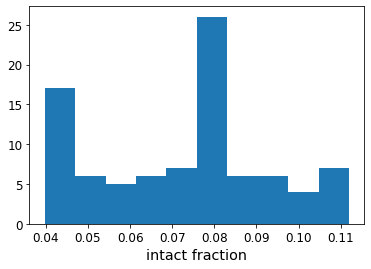

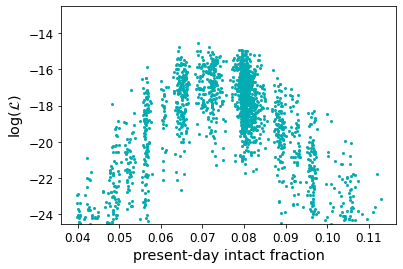

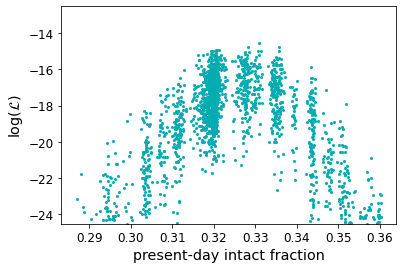

0.2870122373585777 0.3602863080120065


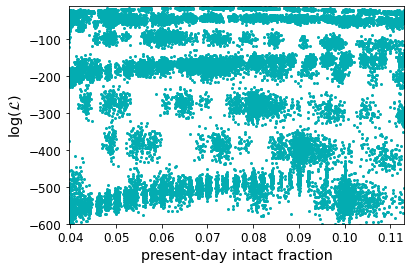

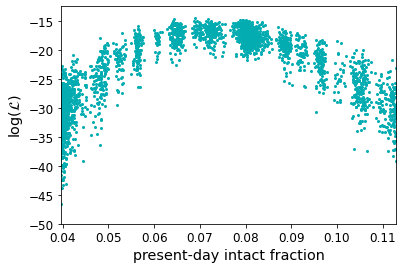

In [118]:
# quick check of the intact fraction distribution of good models (take median across all samples of each tuple)
plt.hist(good_models.groupby(['ms','bs','cs','fs']).median('intact_fracs').intact_fracs)
plt.xlabel('intact fraction')
plt.show()

median_logLs = recovery.groupby(['ms','bs','cs','fs']).max('logLs').logLs
median_intact_fracs = recovery.groupby(['ms','bs','cs','fs']).median('intact_fracs').intact_fracs
#plt.scatter(median_intact_fracs, median_logLs, s=4, color='#03acb1')
plt.scatter(good_models.intact_fracs, good_models.logLs, s=4, color='#03acb1')
#plt.vlines(x=0.53, ymin=min(median_logLs), ymax=max(median_logLs), linestyles='--', color='r', label=r'1-$\sigma$')
plt.xlabel('present-day intact fraction')
plt.ylabel(r'log($\mathcal{L}$)')
plt.ylim([good_models.logLs.min(), good_models.logLs.max()+2])
#plt.xlim([0.03, 0.125])
#plt.legend()
plt.savefig(path+'figures/intact-vs-logL.png', facecolor='white', bbox_inches='tight')
plt.show()

#plt.scatter(median_intact_fracs, median_logLs, s=4, color='#03acb1')
plt.scatter(good_models.disrupted_fracs, good_models.logLs, s=4, color='#03acb1')
#plt.vlines(x=0.53, ymin=min(median_logLs), ymax=max(median_logLs), linestyles='--', color='r', label=r'1-$\sigma$')
plt.xlabel('present-day intact fraction')
plt.ylabel(r'log($\mathcal{L}$)')
plt.ylim([good_models.logLs.min(), good_models.logLs.max()+2])
#plt.xlim([0.03, 0.125])
#plt.legend()
#plt.savefig(path+'figures/disrupted-vs-logL.png', facecolor='white', bbox_inches='tight')
plt.show()
print(np.min(good_models.disrupted_fracs), np.max(good_models.disrupted_fracs))

plt.scatter(recovery.intact_fracs, recovery.logLs, s=4, color='#03acb1')
plt.xlabel('present-day intact fraction')
plt.ylabel(r'log($\mathcal{L}$)')
plt.xlim([good_models.intact_fracs.min(), good_models.intact_fracs.max()])
plt.ylim([-600, good_models.logLs.max()+2])
plt.show()

recovery_04 = recovery.loc[recovery.fs==0.4]
plt.scatter(recovery_04.intact_fracs, recovery_04.logLs, s=4, color='#03acb1')
plt.xlabel('present-day intact fraction')
plt.ylabel(r'log($\mathcal{L}$)')
plt.xlim([good_models.intact_fracs.min(), good_models.intact_fracs.max()])
plt.ylim([-50, good_models.logLs.max()+2])
plt.show()

In [45]:
print("intact frac peak: ", good_models.loc[good_models.logLs == np.max(good_models.logLs)].intact_fracs)
print("intact frac left wing: ", good_models.loc[good_models.intact_fracs == np.min(good_models.intact_fracs)].intact_fracs)
print("intact frac right wing: ", np.max(good_models.loc[good_models.intact_fracs < 0.12].intact_fracs))
print("")
print("now out of planet hosts...")
print("")
print("intact frac peak: ", good_models.loc[good_models.logLs == np.max(good_models.logLs)].intact_fracs/0.4)
print("intact frac left wing: ", good_models.loc[good_models.intact_fracs == np.min(good_models.intact_fracs)].intact_fracs/0.4)
print("intact frac right wing: ", np.max(good_models.loc[good_models.intact_fracs < 0.12].intact_fracs)/0.4)

intact frac peak:  150692    0.069031
Name: intact_fracs, dtype: float64
intact frac left wing:  202901    0.039714
Name: intact_fracs, dtype: float64
intact frac right wing:  0.11298776264142232

now out of planet hosts...

intact frac peak:  150692    0.172579
Name: intact_fracs, dtype: float64
intact frac left wing:  202901    0.099284
Name: intact_fracs, dtype: float64
intact frac right wing:  0.2824694066035558


Compare the above plot between loguniform age case, 10% age error case, and original stellar age sample.

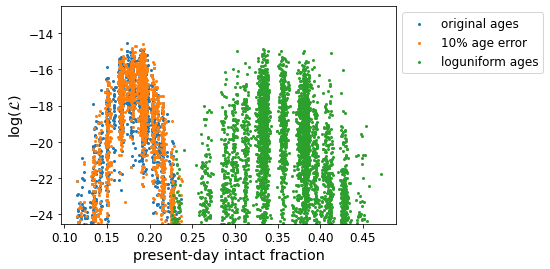

In [101]:
og = pd.read_csv(path+'good_models.csv')
ten = pd.read_csv(path+'good_models_ten.csv')
loguniform = pd.read_csv(path+'good_models_loguniform.csv')

plt.scatter(og.intact_fracs, og.logLs, s=4, label='original ages')
plt.scatter(ten.intact_fracs, ten.logLs, s=4, label='10% age error')
plt.scatter(loguniform.intact_fracs, loguniform.logLs, s=4, label='loguniform ages')
plt.xlabel('present-day intact fraction')
plt.ylabel(r'log($\mathcal{L}$)')
plt.ylim([good_models.logLs.min(), good_models.logLs.max()+2])
plt.legend(bbox_to_anchor=(1, 1))
#plt.savefig(path+'figures/intact-vs-logL.png', facecolor='white', bbox_inches='tight')
plt.show()

Woah...switching to loguniform ages significantly changes the intact fraction I favor, using the real ground truth from Kepler. 

Let's plot the models that are not shared by these two particular cases (original vs loguniform ages).

In [103]:
og

,ms,bs,cs,fs,transit_multiplicities,geom_transit_multiplicities,intact_fracs,disrupted_fracs,logLs
0,-1.0,0.1,1.000000e+08,0.4,"[827.6, 99.60000000000001, 27.6, 9.20000000000...","[1604.8000000000002, 219.20000000000002, 50.40...",0.115244,0.284756,-24.134984
1,-1.0,0.2,1.000000e+08,0.4,"[845.6, 137.20000000000002, 50.0, 23.6, 2.8000...","[1564.8000000000002, 277.2, 112.4, 79.60000000...",0.191492,0.208508,-19.413281
2,-1.0,0.2,1.000000e+08,0.4,"[850.8000000000001, 135.6, 50.0, 21.6, 4.0, 0.8]","[1590.4, 276.8, 116.80000000000001, 80.0, 33.6...",0.191296,0.208704,-18.223242
3,-1.0,0.2,1.000000e+08,0.4,"[865.6, 134.0, 44.800000000000004, 14.4, 7.2, ...","[1574.8000000000002, 274.0, 112.4, 69.2, 35.2,...",0.192180,0.207820,-16.364001
4,-1.0,0.2,1.000000e+08,0.4,"[837.6, 146.4, 48.800000000000004, 15.60000000...","[1542.0, 282.40000000000003, 110.8000000000000...",0.191702,0.208298,-17.738117
...,...,...,...,...,...,...,...,...,...
1874,0.0,0.2,1.584893e+08,0.4,"[842.8000000000001, 140.8, 44.800000000000004,...","[1552.4, 274.8, 106.0, 82.4, 35.6, 6.800000000...",0.190937,0.209063,-17.130827
1875,0.0,0.2,1.584893e+08,0.4,"[866.0, 134.4, 39.6, 20.0, 6.0, 0.4]","[1602.8000000000002, 258.0, 101.60000000000001...",0.190457,0.209543,-16.252200
1876,0.0,0.2,1.584893e+08,0.4,"[846.4000000000001, 137.6, 44.800000000000004,...","[1557.6000000000001, 277.2, 102.80000000000001...",0.191262,0.208738,-17.348511
1877,0.0,0.2,1.584893e+08,0.4,"[867.6, 127.60000000000001, 47.2, 22.8, 4.4, 0.8]","[1584.0, 263.6, 95.2, 81.60000000000001, 34.80...",0.191100,0.208900,-18.585767


In [104]:
loguniform

,ms,bs,cs,fs,transit_multiplicities,geom_transit_multiplicities,intact_fracs,disrupted_fracs,logLs
0,-1.0,0.1,1.000000e+08,0.8,"[880.0, 112.0, 21.6, 9.600000000000001, 4.0, 0.0]","[1704.8000000000002, 272.0, 46.400000000000006...",0.228989,0.571011,-24.194493
1,-1.0,0.2,1.000000e+08,0.7,"[822.5, 116.89999999999999, 39.199999999999996...","[1474.8999999999999, 248.49999999999997, 89.6,...",0.335294,0.364706,-15.764889
2,-1.0,0.2,1.000000e+08,0.7,"[811.3, 114.8, 36.4, 14.7, 3.5, 1.4]","[1453.8999999999999, 239.39999999999998, 107.1...",0.331444,0.368556,-17.940385
3,-1.0,0.2,1.000000e+08,0.7,"[758.8, 135.79999999999998, 37.099999999999994...","[1451.1, 256.2, 91.0, 62.3, 33.599999999999994...",0.334082,0.365918,-18.267343
4,-1.0,0.2,1.000000e+08,0.7,"[755.3, 114.8, 37.099999999999994, 23.79999999...","[1416.1, 256.2, 96.6, 67.89999999999999, 26.59...",0.336542,0.363458,-21.755932
...,...,...,...,...,...,...,...,...,...
3696,0.0,0.3,1.584893e+08,0.7,"[815.5, 140.7, 62.3, 24.5, 5.6, 0.7]","[1366.3999999999999, 303.09999999999997, 144.2...",0.428615,0.271385,-23.145091
3697,0.0,0.3,1.584893e+08,0.7,"[813.4, 163.1, 59.49999999999999, 21.0, 2.8, 0.7]","[1407.6999999999998, 298.2, 152.6, 89.6, 41.3,...",0.425874,0.274126,-24.222057
3698,0.0,0.3,1.584893e+08,0.7,"[807.8, 166.6, 56.0, 23.099999999999998, 7.699...","[1433.6, 297.5, 148.39999999999998, 89.6, 37.8...",0.427739,0.272261,-23.647791
3699,0.0,0.3,1.584893e+08,0.7,"[872.1999999999999, 162.39999999999998, 60.199...","[1481.1999999999998, 315.7, 162.39999999999998...",0.428240,0.271760,-24.094325


In [132]:
good_models.loc[good_models.ms==0]

,ms,bs,cs,fs,transit_multiplicities,geom_transit_multiplicities,intact_fracs,disrupted_fracs,logLs
202901,0.0,0.1,3.981072e+08,0.4,"[817.6, 101.60000000000001, 28.400000000000002...","[1608.8000000000002, 225.20000000000002, 52.80...",0.039714,0.360286,-22.912686
203498,0.0,0.1,1.000000e+09,0.4,"[804.8000000000001, 104.80000000000001, 24.8, ...","[1606.0, 225.20000000000002, 52.40000000000000...",0.040539,0.359461,-24.012849
203512,0.0,0.1,1.000000e+09,0.4,"[835.2, 99.60000000000001, 26.0, 13.6000000000...","[1652.4, 225.20000000000002, 59.2, 41.6, 17.2,...",0.040372,0.359628,-23.838249
204101,0.0,0.1,2.511886e+09,0.4,"[836.0, 98.0, 27.6, 11.600000000000001, 3.2, 0.4]","[1637.6000000000001, 226.4, 60.800000000000004...",0.040487,0.359513,-23.377448
204104,0.0,0.1,2.511886e+09,0.4,"[818.8000000000001, 102.0, 24.0, 11.6000000000...","[1625.2, 220.8, 57.2, 35.2, 20.8, 2.0]",0.040118,0.359882,-24.112380
...,...,...,...,...,...,...,...,...,...
17215,0.0,0.2,1.584893e+08,0.4,"[818.4000000000001, 137.20000000000002, 50.400...","[1546.4, 271.2, 101.2, 86.80000000000001, 32.8...",0.080305,0.319695,-20.143298
17216,0.0,0.2,1.584893e+08,0.4,"[845.2, 134.8, 47.6, 20.400000000000002, 4.800...","[1572.0, 277.6, 123.60000000000001, 72.4, 34.8...",0.079710,0.320290,-16.732105
17217,0.0,0.2,1.584893e+08,0.4,"[836.8000000000001, 133.20000000000002, 49.6, ...","[1572.4, 272.40000000000003, 115.2, 69.6000000...",0.079814,0.320186,-17.140777
17218,0.0,0.2,1.584893e+08,0.4,"[839.6, 142.8, 46.400000000000006, 22.0, 6.0, ...","[1552.8000000000002, 281.2, 114.80000000000001...",0.079618,0.320382,-16.866090


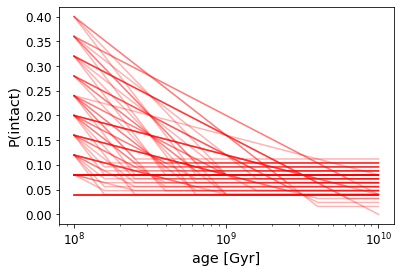

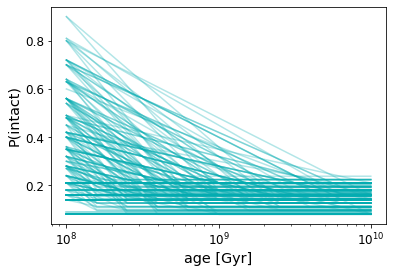

In [120]:
x = np.logspace(8, 10, 1000)

### original ages
og_deduped = og.drop_duplicates(subset=['ms','bs','cs','fs'])
label_flag = True
present_day_intacts = []
for index, row in og_deduped.reset_index().iterrows(): 
    m, b, c, f = row.ms, row.bs, row.cs, row.fs
    if label_flag == True:
        plt.plot(x, build_models(x, m, b, c, f), color='red', zorder=0, label='favored models, Berger ages', alpha=0.3)
    elif label_flag == False:
        plt.plot(x, build_models(x, m, b, c, f), color='red', zorder=0, alpha=0.3)
    label_flag = False  
        
    present_day_intacts.append(calculate_present_day_intact(4e9, m, b, c, f))

plt.xscale('log')
#plt.ylim([0, 0.5])
plt.xlabel('age [Gyr]')
plt.ylabel('P(intact)')
#plt.legend()
plt.show()

### loguniform ages
loguniform_deduped = loguniform.drop_duplicates(subset=['ms','bs','cs','fs'])
label_flag = True
#present_day_intacts = []
for index, row in loguniform_deduped.reset_index().iterrows(): 
    m, b, c, f = row.ms, row.bs, row.cs, row.fs
    if label_flag == True:
        plt.plot(x, build_models(x, m, b, c, f), color='#03acb1', zorder=0, label='favored models, loguniform ages', alpha=0.3)
    elif label_flag == False:
        plt.plot(x, build_models(x, m, b, c, f), color='#03acb1', zorder=0, alpha=0.3)
    label_flag = False  
        
    #present_day_intacts.append(calculate_present_day_intact(4e9, m, b, c, f))
    
plt.xscale('log')
#plt.ylim([0, 0.5])
plt.xlabel('age [Gyr]')
plt.ylabel('P(intact)')
#plt.legend()
plt.show()

In [114]:
loguniform_only = loguniform_deduped.merge(og_deduped, how='inner', on=['ms','bs','cs','fs'])
loguniform_only
#og_only.dropna(subset=['logLs_y'])

,ms,bs,cs,fs,transit_multiplicities_x,geom_transit_multiplicities_x,intact_fracs_x,disrupted_fracs_x,logLs_x,transit_multiplicities_y,geom_transit_multiplicities_y,intact_fracs_y,disrupted_fracs_y,logLs_y


In [125]:
print(present_day_intacts[np.argmax(present_day_intacts)], present_day_intacts[np.argmin(present_day_intacts)])
print(og_deduped.iloc[np.argmax(present_day_intacts)], og_deduped.iloc[np.argmin(present_day_intacts)])


0.11199999999999993 0.016000000000000104
ms                                                                          -0.8
bs                                                                           0.6
cs                                                                   2.51189e+08
fs                                                                           0.4
transit_multiplicities         [843.6, 152.8, 60.400000000000006, 22.40000000...
geom_transit_multiplicities    [1485.6000000000001, 302.0, 158.8, 100.0, 46.4...
intact_fracs                                                             0.23629
disrupted_fracs                                                          0.16371
logLs                                                                   -23.1467
Name: 185, dtype: object ms                                                                          -0.6
bs                                                                             1
cs                                         

In [132]:
print(good_models.loc[good_models.intact_fracs == np.max(good_models.intact_fracs)]) # 1 6 2
print(good_models.loc[good_models.intact_fracs == np.min(good_models.intact_fracs)]) # 0 3 1


        ms   bs            cs   fs  \
62197 -0.8  0.6  2.511886e+08  0.4   

                                  transit_multiplicities  \
62197  [843.6, 152.8, 60.400000000000006, 22.40000000...   

                             geom_transit_multiplicities  intact_fracs  \
62197  [1485.6000000000001, 302.0, 158.8, 100.0, 46.4...       0.23629   

       disrupted_fracs      logLs  
62197          0.16371 -23.146706  
      ms   bs            cs   fs  \
997 -1.0  0.3  1.584893e+08  0.4   

                                transit_multiplicities  \
997  [846.0, 102.0, 30.0, 9.600000000000001, 3.2, 0.4]   

                           geom_transit_multiplicities  intact_fracs  \
997  [1637.6000000000001, 236.8, 50.0, 37.2, 22.400...      0.114509   

     disrupted_fracs     logLs  
997         0.285491 -22.18187  


There are no models that these two regimes have in common!

Compare fraction of intact vs fraction of disrupted, colored by logL

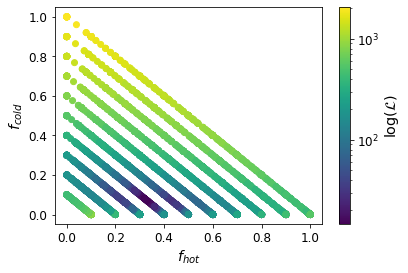

In [138]:
import matplotlib 

# f_hot vs f_cold
deduped_intacts = recovery.groupby(['ms','bs','cs','fs']).median('intact_fracs').intact_fracs
deduped_disrupted = recovery.groupby(['ms','bs','cs','fs']).median('disrupted_fracs').disrupted_fracs
deduped_logLs = recovery.groupby(['ms','bs','cs','fs']).max('logLs').logLs # do I use max or median? 

im = plt.scatter(deduped_disrupted, deduped_intacts, c=-deduped_logLs, norm=matplotlib.colors.LogNorm())
plt.colorbar(im, label=r'log($\mathcal{L}$)')

plt.xlabel(r'$f_{hot}$')
plt.ylabel(r'$f_{cold}$')
#plt.savefig(path+'figures/f_hot-vs-f_cold.png', facecolor='white', bbox_inches='tight')
plt.show()

Finally, let's plot the good models in 3D space, marginalizing only over the planet-host fraction, f.

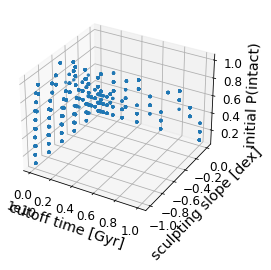

In [90]:
#%matplotlib widget

fig = plt.figure()
ax = plt.axes(projection='3d')

im = ax.scatter3D(good_models.cs, good_models.ms, good_models.bs, s=5)
#im1 = ax.scatter3D(df_keep.loc[df_keep.index==1220].c, df_keep.loc[df_keep.index==1220].m, df_keep.loc[df_keep.index==1220].b, s=8, c='r')
#im2 = ax.scatter3D(df_keep.loc[df_keep.index==73279].c, df_keep.loc[df_keep.index==73279].c, df_keep.loc[df_keep.index==73279].c, s=8, c='purple')
ax.set_xlabel('cutoff time [Gyr]')
#ax.set_xscale('log')
ax.set_ylabel('sculpting slope [dex]')
ax.set_zlabel('initial P(intact)')
#fig.colorbar(im, ax=ax)
#fig.tight_layout()
plt.show()

In [ ]:
def argmedian(x):
    return np.argpartition(x, len(x) // 2)[len(x) // 2] # // is floor division

Build zero bins for both DataFrames

In [6]:
zero_bins = []
transit_multiplicity_zero_bin = []
for j, i in enumerate(truth.transit_multiplicities[:]):
    zero_bins.append(total_stars-np.sum(i))
    temp = truth.reset_index().transit_multiplicities[:][j]
    temp.insert(0,total_stars - np.sum(i))
    transit_multiplicity_zero_bin.append(temp)
truth['transit_multiplicity_zero_bin'] = transit_multiplicity_zero_bin

zero_bins = []
transit_multiplicity_zero_bin = []
for j, i in enumerate(recovery.transit_multiplicities[:]):
    zero_bins.append(total_stars-np.sum(i))
    temp = recovery.reset_index().transit_multiplicities[:][j]
    temp.insert(0,total_stars - np.sum(i))
    transit_multiplicity_zero_bin.append(temp)
recovery['transit_multiplicity_zero_bin'] = transit_multiplicity_zero_bin

Pad transit multiplicities with zeros so they're all the same length.

In [7]:
def pad(lam):
    lam += [0.] * (7 - len(lam)) # pad with zeros to match length of k
    return lam

truth['transit_multiplicities'] = truth.transit_multiplicities.apply(pad)
recovery['transit_multiplicities'] = recovery.transit_multiplicities.apply(pad)


#### See if injection-recovery works for a single model

m = -1, b = 0.5, c = 1e9, f = 0.3

In [8]:
tm = truth.loc[(truth.ms == -1) & (truth.bs == 0.5) & (truth.cs == 1e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities

tm_recovery = recovery.loc[(recovery.ms == -1) & (recovery.bs == 0.5) & (recovery.cs == 1e9) & (np.round(recovery.fs,1) == 0.3)].transit_multiplicities.to_list()

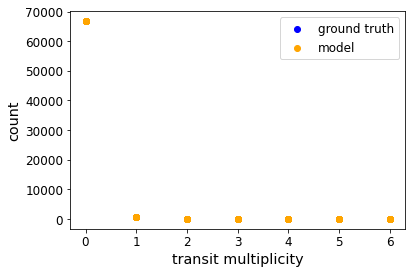

In [9]:
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.scatter(np.arange(len(np.sum(tm))), np.sum(tm), label='ground truth', color='blue')
plt.scatter(np.arange(len(tm_recovery[0])), tm_recovery[0], label='model', color='orange')

for i in tm_recovery[1:]:
    plt.scatter(np.arange(len(i)), i, color='orange')

plt.ylabel('count')
plt.xlabel('transit multiplicity')
#plt.xlim([-0.5,6])
plt.legend()
plt.show()

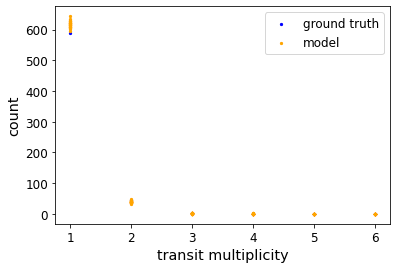

In [10]:
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.scatter(np.arange(len(np.sum(tm)))[1:], np.sum(tm)[1:], label='ground truth', color='blue', s=5)
plt.scatter(np.arange(len(tm_recovery[0]))[1:], tm_recovery[0][1:], label='model', color='orange', s=5)

for i in tm_recovery[1:]:
    plt.scatter(np.arange(len(i))[1:], i[1:], color='orange', s=5)

plt.ylabel('count')
plt.xlabel('transit multiplicity')
#plt.xlim([-0.5,6])
plt.legend()
plt.show()

Ok, so whether or not I include the zero-bin, our injection-recovery envelopes the ground truth, at least for the middling fiducial model I chose. Now how about for all of them?

In [6]:
def prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c):
    """
    Each model run will use an evenly spaced (m,b, cutoff) tuple on a discrete 11x11x11 3D grid
    We're doing log(time), so slope is sampled linearly (everything gets logged together later)
    If a cutoff results in a zero probability, don't bother 

    gi_m: grid index on m axis
    gi_b: grid index on b axis
    gi_c: grid index for cutoff time axis
    """
    #cube[0] = -1e-9*np.logspace(8,10,11)[gi_m] # convert from year to Gyr
    cube[0] = np.linspace(-2,0,3)[gi_m] 
    cube[1] = np.linspace(0,1,3)[gi_b]
    #cube[2] = np.logspace(1e8,1e10,11)
    cube[2] = np.round(np.logspace(8,10,11)[gi_c], 0) # in Ballard et al in prep, they use log(yrs) instead of drawing yrs from logspace
    return cube

In [ ]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1.), 1)
ndim = 3
nparams = 3
for gi_m in range(3):

    for gi_b in range(2):
        gi_b = gi_b + 1

        for gi_c in range(11):
            #print(gi_m, gi_b, gi_c) # so I know where I am
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)

            for f in fs:
                #recovery_min = []
                #recovery_max = []
                #recovery_avg = []
                #print(cube)
                tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (np.round(truth.cs, 0) == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                tm_recovery = recovery.loc[(recovery.ms == cube[0]) & (recovery.bs == cube[1]) & (np.round(recovery.cs, 0) == cube[2]) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()
                
                # take min/max envelopes and avg for tm_recovery
                for i in range(len(np.sum(tm))):
                    fail = False
                    #recovery_min.append(np.amin(np.take(tm_recovery, indices=i, axis=1)))
                    #recovery_max.append(np.amax(np.take(tm_recovery, indices=i, axis=1)))
                    #recovery_avg.append(np.mean(np.take(tm_recovery, indices=i, axis=1)))

                    # flag whenever a model's ground truth is not successfully recovered
                    min_elt = np.amin(np.take(tm_recovery, indices=i, axis=1))
                    max_elt = np.amax(np.take(tm_recovery, indices=i, axis=1))
                    avg_elt = np.mean(np.take(tm_recovery, indices=i, axis=1))
                    
                    if (np.sum(tm)[i] <= max_elt) and (np.sum(tm)[i] >= min_elt):
                        continue
                    else:
                        fail = True
                        #print(cube, f)
                        #print(min_elt, np.sum(tm)[i], max_elt)
                        
                if fail == True:
                    print(cube, f, min_elt, np.sum(tm)[i], max_elt, tm_recovery, i,
                         np.amin(np.take(tm_recovery, indices=i, axis=1)),
                         np.amax(np.take(tm_recovery, indices=i, axis=1)),
                         np.mean(np.take(tm_recovery, indices=i, axis=1)))
                    asdfa
                    
                #print(recovery_min)
                #print(np.sum(tm))
                #afdf

Seems like all models match. But to pass the injection-recovery test, the marginalized posterior must show that the favored model is the original ground truth model.

### Posteriors

#### Fiducial model

In [17]:
tm_fiducial = truth.loc[(np.round(truth.ms, 1) == -1) & (truth.bs == 0.5) & (truth.cs == 1e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities

tm_recovery = recovery.loc[(recovery.ms == -1) & (recovery.bs == 0.5) & (recovery.cs == 1e9) & (np.round(recovery.fs,1) == 0.3)].transit_multiplicities.to_list()

In [158]:
def better_loglike(lam, k):
    """
    Calculate Poisson log likelihood
    Changed 0 handling from simulate.py to reflect https://www.aanda.org/articles/aa/pdf/2009/16/aa8472-07.pdf

    Params: 
    - lam: model predictions for transit multiplicity (list of ints)
    - k: Kepler transit multiplicity (list of ints); can accept alternate ground truths as well

    Returns: Poisson log likelihood (float)
    """

    # in the rare occasion that a simulated system has 7+ planets, throw them into the 6+ bin
    if len(k) < len(lam): 
        extras = lam[len(k):]
        sum_extras = np.sum(extras)
        lam[5] += sum_extras
    lam = lam[:6]
    
    logL = []
    for i in range(len(lam)):
        if lam[i]==0:
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = 0
            logL.append(term1+term2+term3)

        else:
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = k[i]*np.log(lam[i])
            logL.append(term1+term2+term3)

    return np.sum(logL)

#better_loglike(tm_recovery[0], np.sum(tm))

In [46]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1.), 1)
ndim = 3
nparams = 3

ms = []
bs = []
cs = []
fs_for_df = []
all_logLs = []

for gi_m in range(3):
    
    for gi_b in range(2):
        gi_b = gi_b + 1

        for gi_c in range(11):
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
            
            for f in fs:
                
                ms.append(cube[0])
                bs.append(cube[1])
                cs.append(cube[2])
                fs_for_df.append(f)
                
                tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (np.round(truth.cs, 0) == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                tm_recovery = recovery.loc[(recovery.ms == cube[0]) & (recovery.bs == cube[1]) & (np.round(recovery.cs, 0) == cube[2]) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()
                
                # calculate logL for each realization of each model, using tm as the ground truth
                logLs = []
                for i in range(len(tm_recovery)):
                    logL = better_loglike(tm_recovery[i], np.sum(tm_fiducial))
                    logLs.append(logL)
                
                # get best logL for each model
                best_logL = np.max(logLs)
                    
                all_logLs.append(best_logL)
                

In [47]:
model_logLs = pd.DataFrame({'m': ms, 'b': bs, 'c': cs, 'f': fs_for_df, 'logL': all_logLs})
model_logLs

,m,b,c,f,logL
0,-2.0,0.5,1.000000e+08,0.1,-246.029389
1,-2.0,0.5,1.000000e+08,0.1,-246.029389
2,-2.0,0.5,1.000000e+08,0.1,-246.029389
3,-2.0,0.5,1.000000e+08,0.2,-132.552072
4,-2.0,0.5,1.000000e+08,0.2,-132.552072
...,...,...,...,...,...
3295,0.0,1.0,1.000000e+10,0.9,-2467.495664
3296,0.0,1.0,1.000000e+10,0.9,-2467.495664
3297,0.0,1.0,1.000000e+10,1.0,-2860.027559
3298,0.0,1.0,1.000000e+10,1.0,-2860.027559


[-603561.5948414556, -675303.3075248096, -1120593.679552332]


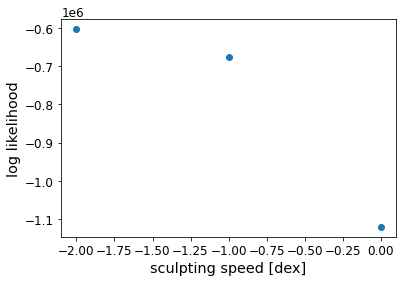

In [162]:
# marginalize in 1D
marginalized_logLs = []
for gi_m in range(3):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.m == cube[0])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
print(marginalized_logLs)

plt.scatter(truth.ms.unique(), marginalized_logLs)
plt.ylabel("log likelihood")
plt.xlabel("sculpting speed [dex]")
plt.show()

In [189]:
model_logLs.loc[np.round(model_logLs.m, 1) == -2].groupby(['c','b']).mean('logL').reset_index().logL.sum()

-12071.231896829113

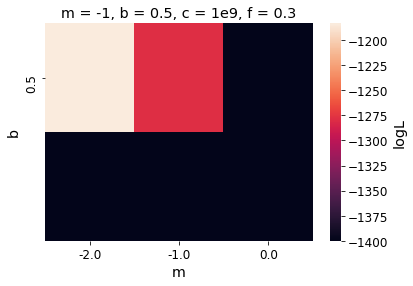

In [54]:
piv = model_logLs.loc[model_logLs.f == 0.3].groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','b']).sum('logL').reset_index()

piv = piv.pivot("b","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), cbar_kws={'label': 'logL'}, vmin=-1400)
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -1, b = 0.5, c = 1e9, f = 0.3')
plt.show()

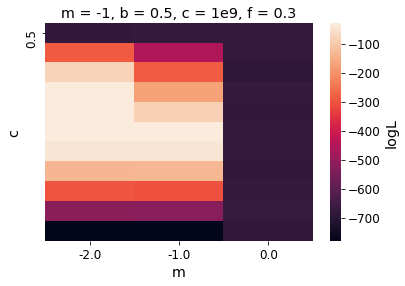

In [147]:
piv = model_logLs.loc[model_logLs.f == 0.3].groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','c']).sum('logL').reset_index()

piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -1, b = 0.5, c = 1e9, f = 0.3')
plt.show()

#### Check 1D marginalized posteriors, and finish this for full set of m and b. Then do this for a few other models. 

There are the following degeneracies: when the ground truth is moderate sculpting, we favor moderate sculpting, as well as 1) moderate longevity and initial intact fraction but fast sculpting; and, to a lesser extent, 2) no sculpting and moderate initial intact fraction. How can that be? I guess there are so few stars younger than 1 Gyr that calling it moderate is a bit disingenous. Perhaps I should try another slice of model space, close to 4 or 5 Gyrs. 

#### Now, for all models

In [ ]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1.), 1)
ndim = 3
nparams = 3

ms = []
bs = []
cs = []
fs_for_df = []
all_logLs = []

for gi_m in range(3):
    
    for gi_b in range(2):
        gi_b = gi_b + 1

        for gi_c in range(3):
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
            
            for f in fs:
                
                ms.append(cube[0])
                bs.append(cube[1])
                cs.append(cube[2])
                fs_for_df.append(f)
                
                tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (truth.cs == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                tm_recovery = recovery.loc[(recovery.ms == cube[0]) & (recovery.bs == cube[1]) & (recovery.cs == cube[2]) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()
                
                # calculate logL for each realization of each model, using tm as the ground truth
                logLs = []
                for i in range(len(tm_recovery)):
                    logL = better_loglike(tm_recovery[i], np.sum(tm_fiducial))
                    logLs.append(logL)
                
                # get best logL for each model
                best_logL = np.amax(logLs)
                all_logLs.append(best_logL)
                

### Quick, fiducial plots for ERES slides

Show example difference in observed transit multiplicity yields for intact vs disrupted systems

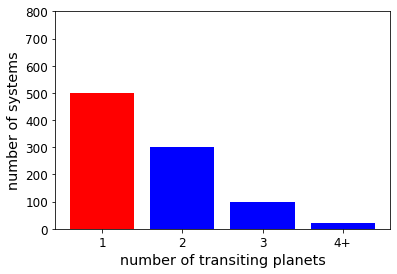

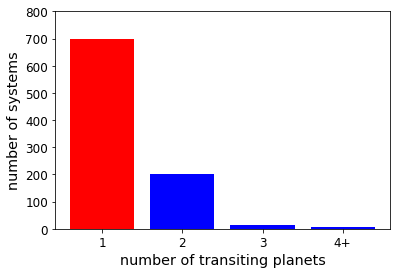

In [90]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#bar_eres = pd.DataFrame({'transits': ['0', '1', '2', '3+']}) # for the x axis label
bar_eres = pd.DataFrame({'transits': ['1', '2', '3', '4+']}) # for the x axis label
c = ['red', 'blue', 'blue', 'blue'] # bar colors

plt.bar(bar_eres.transits, [500, 300, 100, 20], color=c)
plt.xlabel('number of transiting planets')
plt.ylabel('number of systems')
plt.ylim([0, 800])
#plt.savefig(path+'figures/intact.png', facecolor='white', edgecolor='white', bbox_inches='tight')
plt.show()

c = ['red', 'blue', 'blue', 'blue'] # bar colors
plt.bar(bar_eres.transits, [700, 200, 15, 5], color=c)
plt.xlabel('number of transiting planets')
plt.ylabel('number of systems')
plt.ylim([0, 800])
#plt.savefig(path+'figures/disrupted.png', facecolor='white', edgecolor='white', bbox_inches='tight')
plt.show()

### Comparison with PAST Collaboration's Kinematic Ages

Plot Figure 4, Yang+ 2022 from http://www.lamost.org/publications/upload/2022/Yang%20Jiayi-AJ(2022).pdf

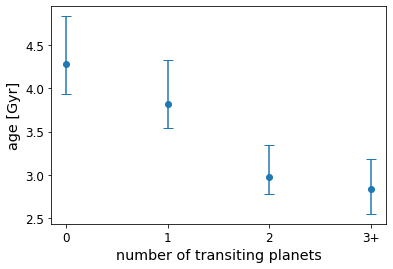

In [109]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

chen_comparison = pd.DataFrame({'multi': ['0', '1', '2', '3+'], 
                               'age': [4.28, 3.82, 2.98, 2.84],
                               'err1': [0.55, 0.5, 0.36, 0.34],
                               'err2': [0.35, 0.28, 0.2, 0.29]})

#plt.errorbar([1], [np.median(ones.iso_age)], yerr=[[-np.median(ones.iso_age_err2)], [np.median(ones.iso_age_err1)]], fmt='o')
plt.errorbar(chen_comparison.multi, chen_comparison.age, yerr=[chen_comparison.err2, chen_comparison.err1],
            fmt='o', capsize=5)

plt.ylabel('age [Gyr]')
plt.xlabel('number of transiting planets')
#plt.savefig(path+'figures/past-ii.png', facecolor='white', edgecolor='white', bbox_inches='tight')
plt.show()

Do any sculpting laws produce distributions that match the PAST data?

In [208]:
me_vs_past = pd.read_csv(path+'past_ii_recovery.csv', sep=',')
me_vs_past

,ms,bs,cs,fs,nontransit_age_maxes,nontransit_age_mins,ones_age_maxes,ones_age_mins,twos_age_maxes,twos_age_mins,threes_age_maxes,threes_age_mins
0,-2.0,0.0,1.000000e+08,0.1,5.903495,1.760284,5.817271,1.772852,5.492887,1.658351,NaN,NaN
1,-2.0,0.0,1.000000e+08,0.2,5.903301,1.760487,5.821405,1.763301,5.402262,1.629167,NaN,NaN
2,-2.0,0.0,1.000000e+08,0.3,5.902648,1.760186,5.807636,1.767149,5.805735,1.788088,NaN,NaN
3,-2.0,0.0,1.000000e+08,0.4,5.901691,1.760346,5.869113,1.761241,5.777778,1.717556,NaN,NaN
4,-2.0,0.0,1.000000e+08,0.5,5.901868,1.760148,5.863256,1.791568,5.425161,1.499355,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
21605,0.0,1.0,1.000000e+10,1.0,5.908368,1.762983,NaN,NaN,NaN,NaN,NaN,NaN
21606,0.0,1.0,1.000000e+10,1.0,5.907817,1.762882,NaN,NaN,NaN,NaN,NaN,NaN
21607,0.0,1.0,1.000000e+10,1.0,5.905314,1.761853,NaN,NaN,NaN,NaN,NaN,NaN
21608,0.0,1.0,1.000000e+10,1.0,5.908594,1.762937,NaN,NaN,NaN,NaN,NaN,NaN


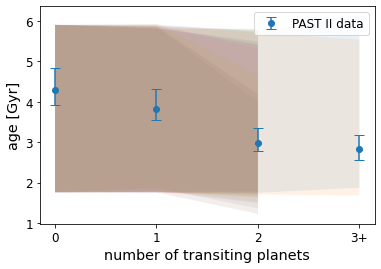

In [209]:
for row, j in enumerate(me_vs_past):
    plt.fill_between(['0', '1', '2', '3+'], [me_vs_past['nontransit_age_maxes'][row], 
                                            me_vs_past['ones_age_maxes'][row],
                                            me_vs_past['twos_age_maxes'][row],
                                            me_vs_past['threes_age_maxes'][row]], 
                     [me_vs_past['nontransit_age_mins'][row], me_vs_past['ones_age_mins'][row],
                      me_vs_past['twos_age_mins'][row], me_vs_past['threes_age_mins'][row]],
                    alpha=0.1)
plt.errorbar(chen_comparison.multi, chen_comparison.age, yerr=[chen_comparison.err2, chen_comparison.err1],
        fmt='o', capsize=5, label='PAST II data')
    
plt.ylabel('age [Gyr]')
plt.xlabel('number of transiting planets')
plt.legend()
plt.show()

...no. But let's do another check. Let's plot the median age histogram for each multiplicity bin for the two favored model tuples that span the favored present-day intact fraction. 

In [315]:
def collect_age_histograms(df, f):

    """
    Collect age spread across different transit multiplicity bins, given a model. 
    Transit multiplicities are capped at 3+

    Inputs: 
    - df: read-in DataFrames of the simulated planetary system products of injection_recovery_main.py
    - f: fraction of planet-hosting stars

    Outputs:
    - total: Pandas DataFrame with yield counts for each planet row

    """

    # if f < 1, randomly steal some non-nontransits for the nontransits gang
    samples_indices = df.sample(frac=1-f, replace=True, random_state=42).index 
    df.loc[samples_indices, 'transit_status'] = 0
    
    # isolate transiting systems
    transit = df.loc[df['transit_status']==1]

    # create column counting number of planets per system
    transit['yield'] = 1
    #transit = transit.groupby(['kepid', 'iso_age'])[['yield']].count().reset_index()
    transit['yield'] = transit.groupby(["kepid", "iso_age"])["yield"].transform("count")
    
    # isolate non-transiting systems
    #nontransit = df.loc[df['transit_status']==0] # that double counts systems with planets that transit/don't 
    nontransit = df.loc[~df.kepid.isin(transit.kepid.unique())]
    nontransit['yield'] = 0
    
    # re-combine, with yields
    #nontransit['yield'] = 0
    total = pd.concat([nontransit, transit])
    #print(len(df.kepid.unique()), len(total.kepid.unique()))

    #print(transit.groupby('kepid').count().reset_index().groupby('iso_teff').count())
    
    return total, transit, nontransit


In [316]:
#df1 = pd.read_csv(path+'data/transits1_6_2_10.csv', sep=',')#, on_bad_lines='skip')
#df2 = pd.read_csv(path+'data/transits0_3_1_10.csv', sep=',')#, on_bad_lines='skip')

df1 = pd.read_csv(path+'data/transits0_1_0.csv', sep='\t')#, on_bad_lines='skip')
df2 = pd.read_csv(path+'data/transits2_10_7.csv', sep='\t')#, on_bad_lines='skip')


In [314]:
total1, transit1, nontransit1 = collect_age_histograms(df1, f=0.4)
total2, transit2, nontransit2 = collect_age_histograms(df2, f=0.4)

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

69296 69296


/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


69296 69296


What is the range of N=1 and N=2 systems that are drawn from intact vs disrupted? 

In [331]:
print("FIRST MODEL: ")
ones = total1.loc[total1['yield']==1]
twos = total1.loc[total1['yield']==2]
multis = total1.loc[total1['yield']>2]
print("single transit systems drawn from intact vs disrupted: ")
print(len(ones.loc[ones.intact_flag=='intact'].kepid.unique())/len(ones.kepid.unique()),
      len(ones.loc[ones.intact_flag=='disrupted'].kepid.unique())/len(ones.kepid.unique()))
print("")

print("double transit systems drawn from intact vs disrupted: ")
print(len(twos.loc[twos.intact_flag=='intact'].kepid.unique())/len(twos.kepid.unique()),
      len(twos.loc[twos.intact_flag=='disrupted'].kepid.unique())/len(twos.kepid.unique()))
print("")

print("multi transit systems drawn from intact vs disrupted: ")
print(len(multis.loc[multis.intact_flag=='intact'].kepid.unique())/len(multis.kepid.unique()),
      len(multis.loc[multis.intact_flag=='disrupted'].kepid.unique())/len(multis.kepid.unique()))

print("SECOND MODEL: ")

ones = total2.loc[total2['yield']==1]
twos = total2.loc[total2['yield']==2]
multis = total2.loc[total2['yield']>2]
print("single transit systems drawn from intact vs disrupted: ")
print(len(ones.loc[ones.intact_flag=='intact'].kepid.unique())/len(ones.kepid.unique()),
      len(ones.loc[ones.intact_flag=='disrupted'].kepid.unique())/len(ones.kepid.unique()))
print("")

print("double transit systems drawn from intact vs disrupted: ")
print(len(twos.loc[twos.intact_flag=='intact'].kepid.unique())/len(twos.kepid.unique()),
      len(twos.loc[twos.intact_flag=='disrupted'].kepid.unique())/len(twos.kepid.unique()))
print("")

print("multi transit systems drawn from intact vs disrupted: ")
print(len(multis.loc[multis.intact_flag=='intact'].kepid.unique())/len(multis.kepid.unique()),
      len(multis.loc[multis.intact_flag=='disrupted'].kepid.unique())/len(multis.kepid.unique()))

FIRST MODEL: 
single transit systems drawn from intact vs disrupted: 
0.16412213740458015 0.8358778625954199

double transit systems drawn from intact vs disrupted: 
0.6526315789473685 0.3473684210526316

multi transit systems drawn from intact vs disrupted: 
1.0 0.0
SECOND MODEL: 
single transit systems drawn from intact vs disrupted: 
0.2908567314614831 0.709143268538517

double transit systems drawn from intact vs disrupted: 
0.8682634730538922 0.1317365269461078

multi transit systems drawn from intact vs disrupted: 
1.0 0.0


In [283]:
nontransit1 = nontransit1.drop_duplicates(subset='kepid')
nontransit2 = nontransit2.drop_duplicates(subset='kepid')

transit1 = transit1.drop_duplicates(subset='kepid')
transit2 = transit2.drop_duplicates(subset='kepid')

In [308]:
total1.loc[~(total1]

,Unnamed: 0_x,kepid,iso_teff_x,iso_teff_err1_x,iso_teff_err2_x,feh_x_x,feh_err1_x,feh_err2_x,iso_age_x,iso_age_err1_x,...,mutual_incl_y,ecc_y,omega_y,lambda_ks_y,second_terms_y,geom_transit_status_y,transit_status_y,prob_detections_y,sn_y,yield_y
0,35,1027900,5772.2,108.1,-103.0,-0.04,0.25,-0.30,6.93,3.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,43,1161092,6340.5,158.2,-157.6,-0.72,0.30,-0.30,2.73,0.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,65,1164407,6961.9,162.7,-134.3,-0.22,0.25,-0.35,1.30,0.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,156,1435930,5848.4,109.8,-111.9,-0.30,0.35,-0.25,4.53,2.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,356,1870799,5965.5,122.8,-117.9,-0.52,0.30,-0.30,8.55,1.83,...,0.223833,0.239883,0.365692,5.750839e+47,0.053416,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,68968,12554500,5578.1,110.5,-109.3,-0.20,0.30,-0.30,10.51,2.76,...,-0.345267,0.015136,3.464329,4.608596e+47,0.059123,0.0,0.0,0.0,0.0,0.0
1426,69023,12599807,6382.9,125.7,-127.9,-0.22,0.30,-0.30,2.51,0.86,...,0.184813,0.020893,1.269977,5.454815e+47,0.017244,0.0,0.0,0.0,0.0,0.0
1427,69151,12689380,6176.5,135.8,-112.5,-0.22,0.30,-0.30,3.28,1.52,...,0.339653,0.057544,5.472621,4.867570e+47,0.058692,0.0,0.0,0.0,0.0,0.0
1428,69269,12884536,5836.5,123.5,-117.3,-0.68,0.35,-0.25,10.33,1.68,...,-0.209137,0.524807,0.459342,5.087257e+47,0.167327,0.0,0.0,0.0,0.0,0.0


In [284]:
total1 = pd.concat([transit1, nontransit1])
total2 = pd.concat([transit2, nontransit2])

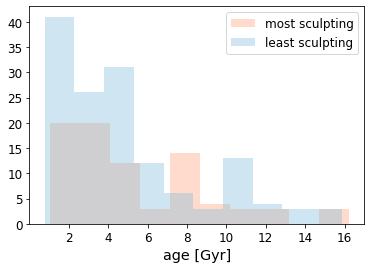

In [329]:
plt.hist(total1.loc[total1['yield']>2].iso_age, alpha=1., 
         label='most sculpting', color='#fedbcc')
plt.hist(total2.loc[total2['yield']>2].iso_age, alpha=0.4, 
         label='least sculpting', color='#89bedc')
plt.legend()
plt.xlabel('age [Gyr]')
plt.show()

What are the intact fractions of these two models, per transit multiplicity bin? 

In [113]:
df_yield1 = df1.merge(total1, on='kepid')
df_yield2 = df2.merge(total2, on='kepid')

In [388]:
zeros = df_yield1.loc[df_yield1['yield']==0]
ones = df_yield1.loc[df_yield1['yield']==1]
twos = df_yield1.loc[df_yield1['yield']==2]
threes = df_yield1.loc[df_yield1['yield']==3]

zeros_intact = zeros.loc[zeros['intact_flag_x']=='intact'].kepid.unique()
zeros_disrupted = zeros.loc[zeros['intact_flag_x']=='disrupted'].kepid.unique()
print(len(zeros_intact)/(len(zeros_intact) + len(zeros_disrupted)))

ones_intact = ones.loc[ones['intact_flag_x']=='intact'].kepid.unique()
ones_disrupted = ones.loc[ones['intact_flag_x']=='disrupted'].kepid.unique()
print(len(ones_intact)/(len(ones_intact) + len(ones_disrupted)))

twos_intact = twos.loc[twos['intact_flag_x']=='intact'].kepid.unique()
twos_disrupted = twos.loc[twos['intact_flag_x']=='disrupted'].kepid.unique()
print(len(twos_intact)/(len(twos_intact) + len(twos_disrupted)))

threes_intact = threes.loc[threes['intact_flag_x']=='intact'].kepid.unique()
threes_disrupted = threes.loc[threes['intact_flag_x']=='disrupted'].kepid.unique()
print(len(threes_intact)/(len(threes_intact) + len(threes_disrupted)))

0.10215553554309618
0.1636500754147813
0.6509433962264151
1.0


In [391]:
zeros = df_yield2.loc[df_yield2['yield']==0]
ones = df_yield2.loc[df_yield2['yield']==1]
twos = df_yield2.loc[df_yield2['yield']==2]
threes = df_yield2.loc[df_yield2['yield']==3]

zeros_intact = zeros.loc[zeros['intact_flag_x']=='intact'].kepid.unique()
zeros_disrupted = zeros.loc[zeros['intact_flag_x']=='disrupted'].kepid.unique()
print(len(zeros_intact)/(len(zeros_intact) + len(zeros_disrupted)))

ones_intact = ones.loc[ones['intact_flag_x']=='intact'].kepid.unique()
ones_disrupted = ones.loc[ones['intact_flag_x']=='disrupted'].kepid.unique()
print(len(ones_intact)/(len(ones_intact) + len(ones_disrupted)))

twos_intact = twos.loc[twos['intact_flag_x']=='intact'].kepid.unique()
twos_disrupted = twos.loc[twos['intact_flag_x']=='disrupted'].kepid.unique()
print(len(twos_intact)/(len(twos_intact) + len(twos_disrupted)))

threes_intact = threes.loc[threes['intact_flag_x']=='intact'].kepid.unique()
threes_disrupted = threes.loc[threes['intact_flag_x']=='disrupted'].kepid.unique()
print(len(threes_intact)/(len(threes_intact) + len(threes_disrupted)))

0.1856974904567688
0.2933914306463326
0.8
1.0


In [403]:
pal = sns.color_palette('Reds')
print(pal.as_hex())
pal.as_hex()

['#fedbcc', '#fcaf93', '#fc8161', '#f44f39', '#d52221', '#aa1016']


['#fedbcc', '#fcaf93', '#fc8161', '#f44f39', '#d52221', '#aa1016']

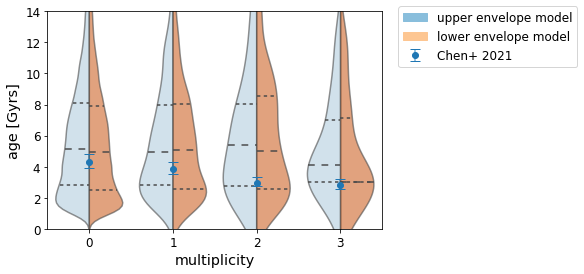

In [340]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

blue_patch = mpatches.Patch(color='#89bedc', label='upper envelope model')
orange_patch = mpatches.Patch(color='#fdc692', label='lower envelope model')

ax1 = sns.violinplot(data=total1_sys, x="yield", y="iso_age", hue=True, hue_order=[True, False], inner='quart',
                     palette='Blues', split=True, saturation=0.75)
ax2 = sns.violinplot(data=total2_sys, x="yield", y="iso_age", hue=True, hue_order=[False, True], inner='quart',
                     palette='Oranges', split=True, alpha=0.3, saturation=0.75)
ax3 = plt.errorbar(chen_comparison.multi, chen_comparison.age, yerr=[chen_comparison.err2, chen_comparison.err1],
        fmt='o', capsize=5, label='Chen+ 2021')

for violin in ax1.collections:
    violin.set_alpha(0.6)
for violin in ax2.collections:
    violin.set_alpha(0.6)
    
#ax1.legend_ = None
#ax2.legend_ = None
plt.ylim([0,14])
plt.xlim([-0.5, 3.5])
plt.xlabel('multiplicity')
plt.ylabel('age [Gyrs]')
plt.legend(handles=[blue_patch, orange_patch, ax3], bbox_to_anchor=[1.6, 1.05])
plt.savefig(path+'figures/age_vs_multiplicity2.png', format='png', bbox_inches='tight')
plt.show()

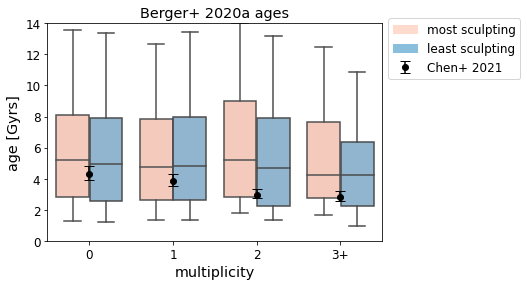

In [330]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.colors as colors

blue_patch = mpatches.Patch(color='#fedbcc', label='most sculpting')
orange_patch = mpatches.Patch(color='#89bedc', label='least sculpting')

ax1 = sns.boxplot(data=total1, x="yield", y="iso_age", hue=True, hue_order=[True, False],
                     palette='Reds', orient="v", whis=(5,95), showfliers=False)
ax2 = sns.boxplot(data=total2, x="yield", y="iso_age", hue=True, hue_order=[False, True], 
                     palette='Blues', orient="v", whis=(5,95), showfliers=False)
ax3 = plt.errorbar(chen_comparison.multi, chen_comparison.age, yerr=[chen_comparison.err2, chen_comparison.err1],
        fmt='o', capsize=5, color='k', label='Chen+ 2021')

#for box in ax1.collections:
#    box.set_alpha(0.6)
#for box in ax2.collections:
#    box.set_alpha(0.6)
    
#ax1.legend_ = None
#ax2.legend_ = None

for patch in ax1.artists:
    fc = patch.get_facecolor()
    patch.set_facecolor(colors.to_rgba(fc, 0.6))
    
for patch in ax2.artists:
    fc = patch.get_facecolor()
    patch.set_facecolor(colors.to_rgba(fc, 0.6))
    
plt.ylim([0,14])
plt.xticks([0,1,2,3], ['0','1','2','3+'])
plt.xlim([-0.5, 3.5])
plt.xlabel('multiplicity')
plt.ylabel('age [Gyrs]')
plt.legend(handles=[blue_patch, orange_patch, ax3], loc='upper left', bbox_to_anchor=[1.0, 1.05])
#plt.legend(handles=[blue_patch, orange_patch, ax3], loc='upper right')
plt.title('Berger+ 2020a ages')
plt.savefig(path+'figures/age_vs_multiplicity_boxplot2.png', format='png', bbox_inches='tight')
plt.show()

#### Sheila's kinematic ages

We are not agreeing with our isochrone ages from the Berger crossmatch. Let's introduce Sheila Sagear's kinematic ages from Gaia. 

In [4]:
hdul = fits.open(path+'kinematic-ages/Kepler_Age_Predictions.fits')

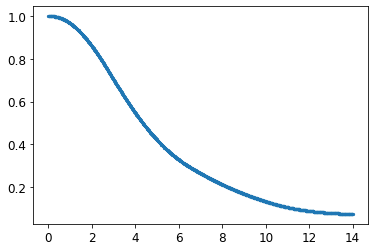

(array([22., 19., 23.,  8.,  9.,  5.,  6.,  4.,  1.,  3.]),
 array([ 0.        ,  1.26826827,  2.53653654,  3.8048048 ,  5.07307307,
         6.34134134,  7.60960961,  8.87787788, 10.14614615, 11.41441441,
        12.68268268]),
 <BarContainer object of 10 artists>)

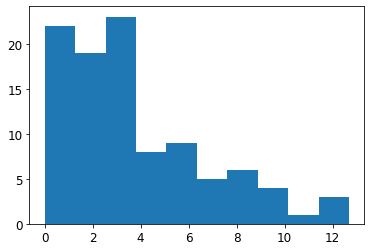

In [5]:
eval_grid = np.linspace(0, 14, 1000)
plt.scatter(eval_grid, hdul[1].data['agepost_MSTO'][0], s=5)
plt.show()

y = hdul[1].data['agepost_MSTO'][0]
plt.hist(np.random.choice(eval_grid, p=y/y.sum(), size=100))

In [6]:
eval_grid = np.linspace(0, 14, 1000)

ages = []
for i in range(len(hdul[1].data)):
    
    # retrieve "posterior" for star
    y = hdul[1].data['agepost_MSTO'][i]

    # evaluate ages
    choice = np.random.choice(eval_grid, p=y/y.sum(), size=100)
    ages.append(choice)
    
hdul_df = pd.DataFrame({'kepid': hdul[1].data['kepid'].byteswap().newbyteorder(), 'age': ages})
hdul_df.head()

,kepid,age
0,757076,"[13.243243243243244, 3.069069069069069, 4.2042..."
1,757099,"[1.6116116116116117, 1.3453453453453452, 6.880..."
2,757137,"[5.115115115115115, 1.961961961961962, 1.86386..."
3,757280,"[2.858858858858859, 6.544544544544545, 8.64664..."
4,891901,"[2.5225225225225225, 6.2642642642642645, 5.577..."


Cross match with Berger+ isochrone ages

In [7]:
berger = pd.read_csv(path+'data/berger_kepler_stellar_fgk.csv')
berger

/Users/chris/anaconda2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (138) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,kepid,tm_designation,teff,teff_err1,teff_err2,logg,logg_err1,logg_err2,feh_x,feh_err1,...,feh_y,feh_err,RUWE,num_gaia_companions,Kmag_final_prov,evstate,logR,is_giant,fractional_err1,fractional_err2
0,757280,2MASS J19242289+3633538,6543,162.0,-194.0,4.082,0.258,-0.172,-0.24,0.25,...,NaN,NaN,0.8704,0,NaN,NaN,0.416641,False,0.161290,-0.129032
1,892195,2MASS J19240520+3638374,5522,194.0,-155.0,3.984,0.510,-0.170,-0.06,0.30,...,NaN,NaN,1.1211,0,NaN,NaN,-0.000869,False,0.244584,-0.322152
2,892667,2MASS J19243045+3637186,6609,159.0,-227.0,4.105,0.246,-0.164,-0.26,0.25,...,NaN,NaN,0.8674,0,NaN,NaN,0.337060,False,0.205128,-0.179487
3,892678,2MASS J19243108+3638316,6137,167.0,-186.0,3.936,0.428,-0.143,-0.26,0.30,...,NaN,NaN,0.9852,1,BinaryCorr,NaN,0.529174,False,0.048649,-0.064865
4,892713,2MASS J19243353+3637220,6106,186.0,-186.0,3.854,0.496,-0.124,-0.24,0.30,...,NaN,NaN,0.9872,1,BinaryCorr,NaN,0.561578,False,0.076389,-0.208333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67375,12935035,2MASS J19204068+5218589,6071,192.0,-234.0,3.992,0.382,-0.127,-0.06,0.25,...,0.012,0.15,1.0144,0,NaN,NaN,0.282849,False,0.161100,-0.332024
67376,12983952,2MASS J19194126+5224230,5365,175.0,-191.0,4.571,0.032,-0.136,0.12,0.25,...,NaN,NaN,1.0901,0,NaN,NaN,0.100715,False,0.179922,-0.217080
67377,12984000,2MASS J19194837+5225067,5835,174.0,-192.0,4.464,0.084,-0.196,-0.26,0.30,...,0.038,0.15,0.9243,0,NaN,NaN,0.335658,False,0.146396,-0.128378
67378,12984200,2MASS J19201625+5224552,5862,161.0,-161.0,4.459,0.084,-0.182,-0.28,0.30,...,-0.050,0.15,1.1178,0,NaN,NaN,0.264109,False,0.184165,-0.203098


In [8]:
berger_ages = []

### draw Berger ages 
for i in range(len(berger)):
    
    # retrieve row for crossmatched star
    y = berger.iloc[i]
    
    # sample from Berger+ 2020a ages
    berger_age = np.random.normal(y.iso_age, 0.5*(y.iso_age_err1 + np.abs(y.iso_age_err2)), 100)
    
    berger_ages.append(berger_age)

In [9]:
berger_ages_df = pd.DataFrame({'kepid': berger.kepid, 'isochrone_ages': berger_ages})
berger_ages_df.head()

,kepid,isochrone_ages
0,757280,"[1.110494676040362, 1.2149928527233698, 1.0578..."
1,892195,"[14.60915914662316, 17.335810748870262, 12.170..."
2,892667,"[1.679338480246201, 1.4938198196840062, 1.8016..."
3,892678,"[1.7726003496026739, 1.7146367952226902, 1.827..."
4,892713,"[1.3807676305274765, 1.0129951410804945, 1.311..."


In [10]:
kinematic_berger = berger_ages_df.merge(hdul_df, on='kepid')
kinematic_berger.head()

,kepid,isochrone_ages,age
0,757280,"[1.110494676040362, 1.2149928527233698, 1.0578...","[2.858858858858859, 6.544544544544545, 8.64664..."
1,892195,"[14.60915914662316, 17.335810748870262, 12.170...","[3.90990990990991, 5.297297297297297, 3.545545..."
2,892667,"[1.679338480246201, 1.4938198196840062, 1.8016...","[9.17917917917918, 13.761761761761761, 9.54354..."
3,892678,"[1.7726003496026739, 1.7146367952226902, 1.827...","[1.7377377377377377, 8.926926926926926, 11.687..."
4,892713,"[1.3807676305274765, 1.0129951410804945, 1.311...","[11.51951951951952, 6.544544544544545, 4.07807..."


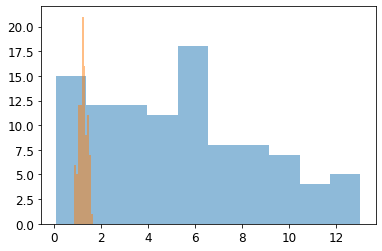

In [11]:
# a preview of what's to come
plt.hist(kinematic_berger.iloc[0].age, label='kinematic', alpha=0.5)
plt.hist(kinematic_berger.iloc[0].isochrone_ages, label='isochrone', alpha=0.5)

plt.show()

In [13]:
from scipy import stats

def density_estimation(m1, m2):
    X, Y = np.mgrid[0:14:100j, 0:14:100j]                                                     
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = stats.gaussian_kde(values)                                                                 
    Z = np.reshape(kernel(positions).T, X.shape)
    return X, Y, Z

#X,Y,Z = density_estimation(row.age, row.isochrone_ages)

#CS = plt.contour(X, Y, Z)
#plt.clabel(CS, inline=True, fontsize=10)
#plt.colorbar(CS)

#plt.show()

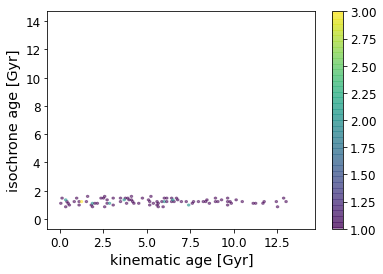

In [24]:
#for i in range(len(kinematic_berger)):
for i in range(1):
    row = kinematic_berger.iloc[i]
    #plt.scatter(row.age, row.isochrone_ages, s=5, color='k', alpha=0.5)
    plt.hexbin(row.age, row.isochrone_ages, alpha=0.5, mincnt=1, extent=[0,14,0,14])
    #X,Y,Z = density_estimation(row.age, row.isochrone_ages)
    #plt.contour(X,Y,Z)

#plt.ylim([0,14])
#plt.xlim([0,14])
plt.ylabel('isochrone age [Gyr]')
plt.xlabel('kinematic age [Gyr]')
plt.colorbar()
plt.show()

What is that even saying? I guess I'll just break out all 100 samples and hexbin everything together.

In [16]:
kinematic_berger_exploded = kinematic_berger.set_index(['kepid']).apply(pd.Series.explode).reset_index() # explode on all columns not "set"

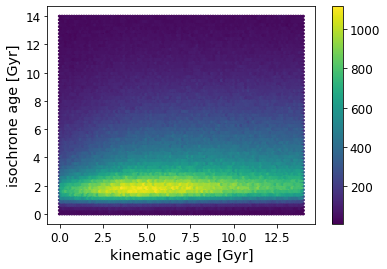

In [17]:
plt.hexbin(kinematic_berger_exploded.age, kinematic_berger_exploded.isochrone_ages, extent=[0,14,0,14])
plt.ylabel('isochrone age [Gyr]')
plt.xlabel('kinematic age [Gyr]')
plt.colorbar()
plt.show()

In [27]:
kinematic_berger_exploded.to_csv(path+'data/kinematic_berger_exploded.csv', index=False)

There was an old way in which Sheila gave me 16th, 50th, and 84th percentile ages, but she later found age distributions to be multi-modal, so she just gave me the straight posteriors (above). The analysis below uses the old data. 

In [ ]:
"""
hdul_df = pd.DataFrame({'kepid': hdul[1].data['kepid'].byteswap().newbyteorder(), 
                        'age16_MSTO': hdul[1].data['age16_MSTO'].byteswap().newbyteorder(),
                       'age50_MSTO': hdul[1].data['age50_MSTO'].byteswap().newbyteorder(), 
                        'age84_MSTO': hdul[1].data['age84_MSTO'].byteswap().newbyteorder()})
hdul_df = pd.DataFrame({'kepid': hdul[1].data['kepid'].byteswap().newbyteorder(), 
                       'agepost_MSTO': hdul[1].data['agepost_MSTO']})
hdul_df
""""

Now for planet hosts

In [18]:
planet_hosts = pd.read_csv(path+'data/pnum_plus_cands_fgk.csv')
kinematic_planet_hosts = planet_hosts.merge(hdul_df, on='kepid')
kinematic_planet_hosts

,kepid,tm_designation,teff,teff_err1,teff_err2,logg,logg_err1,logg_err2,feh_x,feh_err1,...,RUWE,num_gaia_companions,Kmag_final_prov,evstate,logR,is_giant,fractional_err1,fractional_err2,isochrone_ages,age
0,1871056,2MASS J19281070+3722344,6207,112.0,-125.0,3.963,0.195,-0.105,0.24,0.15,...,1.0121,0,NaN,NaN,0.301030,False,0.239496,-0.168067,"[2.417123267872099, 2.2899778755886633, 3.2481...","[5.801801801801802, 8.044044044044044, 6.67067..."
1,1871056,2MASS J19281070+3722344,6207,112.0,-125.0,3.963,0.195,-0.105,0.24,0.15,...,1.0121,0,NaN,NaN,0.301030,False,0.239496,-0.168067,"[2.417123267872099, 2.2899778755886633, 3.2481...","[5.801801801801802, 8.044044044044044, 6.67067..."
2,2019199,2MASS J19295668+3724156,5671,73.0,-73.0,3.942,0.203,-0.087,0.44,0.05,...,1.0013,0,NaN,NaN,0.199206,False,0.436585,-0.217073,"[4.063341864159414, 6.860929178299337, 4.00143...","[5.171171171171171, 12.122122122122121, 10.314..."
3,2161949,2MASS J19271509+3733211,5683,154.0,-154.0,4.326,0.170,-0.187,0.08,0.25,...,0.9061,0,NaN,NaN,0.019532,False,0.527540,-0.487148,"[7.239348519314707, 6.866651856471776, 10.6269...","[13.78978978978979, 2.8728728728728727, 9.1651..."
4,2161949,2MASS J19271509+3733211,5683,154.0,-154.0,4.326,0.170,-0.187,0.08,0.25,...,0.9061,0,NaN,NaN,0.019532,False,0.527540,-0.487148,"[7.239348519314707, 6.866651856471776, 10.6269...","[13.78978978978979, 2.8728728728728727, 9.1651..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,12602999,2MASS J19232978+5141066,6787,182.0,-202.0,3.762,0.285,-0.095,-0.16,0.30,...,1.1522,0,NaN,NaN,0.198382,False,0.465347,-0.475248,"[0.643161435664191, 1.4024422416084175, 0.3317...","[3.755755755755756, 2.4664664664664664, 1.4574..."
838,12690465,2MASS J19184894+5152181,6782,165.0,-260.0,4.249,0.128,-0.192,-0.30,0.25,...,0.9736,1,BinaryCorr,NaN,0.241795,False,0.196629,-0.213483,"[1.0863300694048643, 1.5880067097955468, 1.795...","[6.712712712712713, 9.865865865865866, 9.24924..."
839,12735793,2MASS J19190999+5159373,6185,167.0,-167.0,3.868,0.292,-0.097,0.00,0.25,...,0.9634,0,NaN,NaN,0.106531,False,0.549839,-0.408360,"[1.8429498293563438, 1.2251742055832557, 2.189...","[8.352352352352352, 3.0970970970970972, 2.3263..."
840,12737015,2MASS J19215521+5157540,6059,109.0,-146.0,4.151,0.168,-0.112,0.16,0.15,...,1.0671,0,NaN,NaN,0.324899,False,0.238938,-0.163717,"[1.7467670278476861, 2.752390450464603, 2.1792...","[12.388388388388389, 9.921921921921921, 1.6256..."


Get transit multiplicity for each kepid with planets. Get age spreads for these. Then remove these kepids from the berger DataFrame. Then get the age spread for those kepids. Then plot!

In [19]:
kinematic_planet_hosts.groupby('kepid').count().koi_count.reset_index().groupby('koi_count').count()

,kepid
koi_count,
1,489
2,98
3,31
4,11
5,4


In [20]:
kinematic_planet_hosts['calculated_count'] = kinematic_planet_hosts.groupby('kepid').transform('count').koi_count

I'm not sure whether to calculate the 1-$\sigma$ bounds using the given uncertainties from each star or calculating the standard deviation directly from the mean of each sub-sample.

In [27]:
ones = kinematic_planet_hosts.loc[kinematic_planet_hosts.calculated_count == 1].age50_MSTO
twos = kinematic_planet_hosts.loc[kinematic_planet_hosts.calculated_count == 2].age50_MSTO
threes = kinematic_planet_hosts.loc[kinematic_planet_hosts.calculated_count >= 3].age50_MSTO

ones_mean = np.mean(np.array(ones))
ones_plus = np.std(np.array(ones)) # or do I do np.mean(np.array(^^.age16_MSTO))?
ones_minus = np.std(np.array(ones))
ones_plus = np.mean(np.array(kinematic_planet_hosts.loc[kinematic_planet_hosts.calculated_count == 1].age84_MSTO - ones))
ones_minus = np.mean(np.array(ones - kinematic_planet_hosts.loc[kinematic_planet_hosts.calculated_count == 1].age16_MSTO))

twos_mean = np.mean(np.array(twos))
twos_plus = np.std(np.array(twos))
twos_minus = np.std(np.array(twos))
twos_plus = np.mean(np.array(kinematic_planet_hosts.loc[kinematic_planet_hosts.calculated_count == 2].age84_MSTO - twos))
twos_minus = np.mean(np.array(twos - kinematic_planet_hosts.loc[kinematic_planet_hosts.calculated_count == 2].age16_MSTO))

threes_mean = np.mean(np.array(threes))
threes_plus = np.std(np.array(threes))
threes_minus = np.std(np.array(threes))
threes_plus = np.mean(np.array(kinematic_planet_hosts.loc[kinematic_planet_hosts.calculated_count >= 3].age84_MSTO - threes))
threes_minus = np.mean(np.array(threes - kinematic_planet_hosts.loc[kinematic_planet_hosts.calculated_count >= 3].age16_MSTO))


Remove planet-hosts from Berger-kinematic cross-match

In [28]:
zeros = kinematic_berger.loc[~kinematic_berger.kepid.isin(kinematic_planet_hosts.kepid)].age50_MSTO
zeros_mean = np.mean(np.array(zeros))
zeros_plus = np.std(np.array(zeros))
zeros_minus = np.std(np.array(zeros))
zeros_plus = np.mean(np.array(kinematic_berger.loc[~kinematic_berger.kepid.isin(kinematic_planet_hosts.kepid)].age84_MSTO - zeros))
zeros_minus = np.mean(np.array(zeros - kinematic_berger.loc[~kinematic_berger.kepid.isin(kinematic_planet_hosts.kepid)].age16_MSTO))

Plot

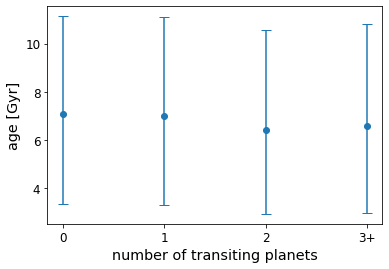

In [29]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

kinematic_comparison = pd.DataFrame({'multi': ['0', '1', '2', '3+'], 
                               'age': [zeros_mean, ones_mean, twos_mean, threes_mean],
                               'err1': [zeros_plus, ones_plus, twos_plus, threes_plus],
                               'err2': [zeros_minus, ones_minus, twos_minus, threes_minus]})

#plt.errorbar([1], [np.median(ones.iso_age)], yerr=[[-np.median(ones.iso_age_err2)], [np.median(ones.iso_age_err1)]], fmt='o')
plt.errorbar(kinematic_comparison.multi, kinematic_comparison.age, 
             yerr=[kinematic_comparison.err2, kinematic_comparison.err1],
            fmt='o', capsize=5)

plt.ylabel('age [Gyr]')
plt.xlabel('number of transiting planets')
#plt.savefig(path+'figures/past-ii.png', facecolor='white', edgecolor='white', bbox_inches='tight')
plt.show()

Unlike PAST II, we do not see changes in age spread with transit multiplicity.

Overplot Berger isochrone ages

In [30]:
planet_hosts = pd.read_csv(path+'data/pnum_plus_cands_fgk.csv')
planet_hosts['calculated_count'] = planet_hosts.groupby('kepid').transform('count').koi_count

ones = planet_hosts.loc[planet_hosts.calculated_count == 1]
ones_mean = np.mean(ones.iso_age)
ones_plus = np.mean(ones.iso_age_err1)
ones_minus = np.mean(ones.iso_age_err2)

twos = planet_hosts.loc[planet_hosts.calculated_count == 2]
twos_mean = np.mean(twos.iso_age)
twos_plus = np.mean(twos.iso_age_err1)
twos_minus = np.mean(twos.iso_age_err2)

threes = planet_hosts.loc[planet_hosts.calculated_count >= 3]
threes_mean = np.mean(threes.iso_age)
threes_plus = np.mean(threes.iso_age_err1)
threes_minus = np.mean(threes.iso_age_err2)

zeros = berger.loc[~berger.kepid.isin(planet_hosts.kepid)]
zeros_mean = np.mean(zeros.iso_age)
zeros_plus = np.mean(zeros.iso_age_err1)
zeros_minus = np.mean(zeros.iso_age_err2)

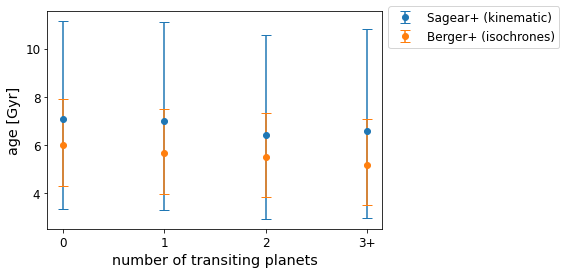

In [32]:
berger_comparison = pd.DataFrame({'multi': ['0', '1', '2', '3+'], 
                               'age': [zeros_mean, ones_mean, twos_mean, threes_mean],
                               'err1': [zeros_plus, ones_plus, twos_plus, threes_plus],
                               'err2': np.abs([zeros_minus, ones_minus, twos_minus, threes_minus])})

plt.errorbar(kinematic_comparison.multi, kinematic_comparison.age, 
             yerr=[kinematic_comparison.err2, kinematic_comparison.err1],
            fmt='o', capsize=5, label='Sagear+ (kinematic)')

plt.errorbar(berger_comparison.multi, berger_comparison.age, 
             yerr=[berger_comparison.err2, berger_comparison.err1],
            fmt='o', capsize=5, label='Berger+ (isochrones)')

plt.ylabel('age [Gyr]')
plt.xlabel('number of transiting planets')
plt.legend(bbox_to_anchor=(1., 1.05))
#plt.savefig(path+'figures/past-ii.png', facecolor='white', edgecolor='white', bbox_inches='tight')
plt.show()

Lucy Lu showed me a similar plot that she made using her own kinematically calibrated ages, on 9/12/23. She plotted individual ages, though, so to better compare against her plot, I remake the above plot for Berger+ ages below. 

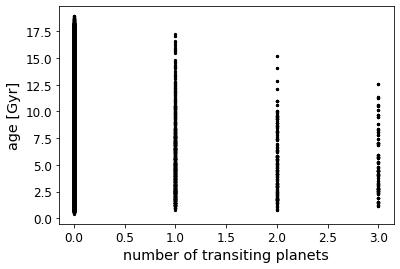

In [15]:
plt.scatter(0*np.ones(len(zeros)), zeros.iso_age, s=5, c='k')
plt.scatter(1*np.ones(len(ones)), ones.iso_age, s=5, c='k')
plt.scatter(2*np.ones(len(twos)), twos.iso_age, s=5, c='k')
plt.scatter(3*np.ones(len(threes)), threes.iso_age, s=5, c='k')

plt.ylabel('age [Gyr]')
plt.xlabel('number of transiting planets')
#plt.legend(bbox_to_anchor=(1., 1.05))
#plt.savefig(path+'figures/past-ii.png', facecolor='white', edgecolor='white', bbox_inches='tight')
plt.show()

In [16]:
len(ones), len(twos), len(threes)

(833, 268, 199)

Compare histograms of multis and singles for isochrones

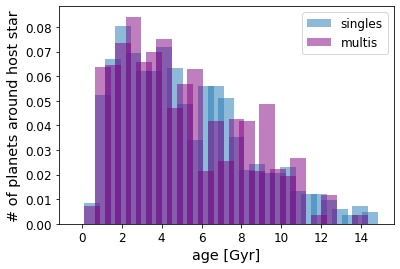

In [92]:
bins = np.linspace(0, 15, 30)
multis = np.histogram(twos.iso_age, bins=bins)[0]*2 + np.histogram(threes.iso_age, bins=bins)[0]*3
num_multis = np.histogram(twos.iso_age, bins=bins)[0] + np.histogram(threes.iso_age, bins=bins)[0]
singles = np.histogram(ones.iso_age, bins=bins)[0]

#plt.hist(ones.iso_age, bins=bins, alpha=0.5, label='singles')
plt.bar(bins[:-1], singles/np.sum(singles), alpha=0.5, label='singles')
plt.bar(bins[:-1], multis/np.sum(multis), alpha=0.5, label='multis', color='purple')
plt.ylabel('# of planets around host star')
plt.xlabel('age [Gyr]')
plt.legend()
plt.show()

Sarah wanted to see the relation between kinematic ages from Sheila and the isochrone ages from Berger.

In [51]:
berger_sagear = berger.merge(hdul_df, on='kepid')
berger_sagear.to_csv(path+'berger_sagear.csv', index=False)

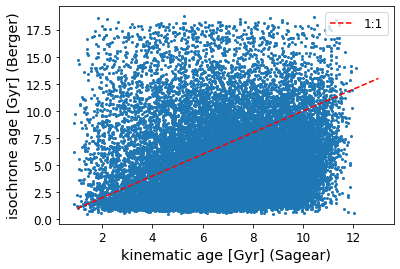

In [50]:
plt.scatter(berger_sagear.age50_MSTO, berger_sagear.iso_age, s=4)
plt.plot(np.linspace(1, 13, 100), np.linspace(1, 13, 100), linestyle='--', color='r', label='1:1')
plt.xlabel('kinematic age [Gyr] (Sagear)')
plt.ylabel('isochrone age [Gyr] (Berger)')
plt.legend()
plt.show()

Sarah: Sheila and I were just having a discussion about how to report her ages-- some of them have weird, non-Gaussian posteriors. This plot is showing the mode of her distributions, on the Sagear axis? (Yes, I had only the medians.)

Gotcha. Sheila and I also just talked about what you discussed. We’re thinking of making a plot in which we bootstrap from Sheila’s “posteriors” for the x-axis (bc they’re weird, non-Gaussian), and I bootstrap from Gaussian approximations based on Berger’s asymmetric age errors. Sheila has sent me her posteriors, and I’m about to send her the crossmatch between her stars and Berger’s (post-cuts). Then, we can make a heatmap based on the ~34K stars that are in both samples.







Let's check that the age posteriors are consistent between Berger and the kinematic ages. We will compare posteriors for three stars, two of which are planet hosts.

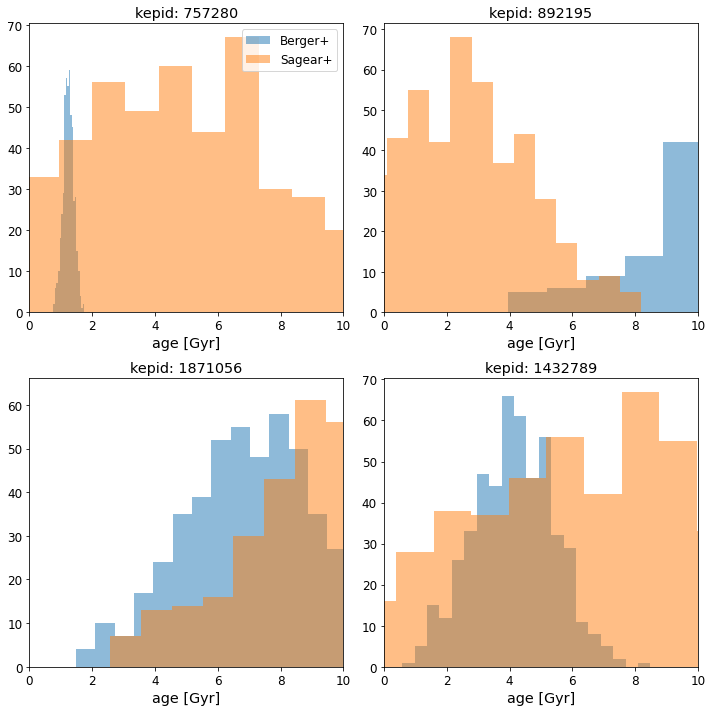

In [189]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

star1 = kinematic_berger.loc[kinematic_berger.kepid==757280]
star2 = kinematic_berger.loc[kinematic_berger.kepid==892195]
star3 = kinematic_planet_hosts.loc[planet_hosts.kepid==1871056].iloc[1]
star4 = kinematic_planet_hosts.loc[planet_hosts.kepid==1432789].iloc[1]

berger1 = np.random.normal(star1.iso_age, 0.5*(star1.iso_age_err1+np.abs(star1.iso_age_err2)), 500)
berger2 = np.random.normal(star2.iso_age, 0.5*(star2.iso_age_err1+np.abs(star2.iso_age_err2)), 500)
berger3 = np.random.normal(star3.iso_age, 0.5*(star3.iso_age_err1+np.abs(star3.iso_age_err2)), 500)
berger4 = np.random.normal(star4.iso_age, 0.5*(star4.iso_age_err1+np.abs(star4.iso_age_err2)), 500)

sagear1 = np.random.normal(star1.age50_MSTO, 0.5*(star1.age50_MSTO-star1.age16_MSTO + star1.age84_MSTO-star1.age50_MSTO), 500)
sagear2 = np.random.normal(star2.age50_MSTO, 0.5*(star2.age50_MSTO-star2.age16_MSTO + star2.age84_MSTO-star2.age50_MSTO), 500)
sagear3 = np.random.normal(star3.age50_MSTO, 0.5*(star3.age50_MSTO-star3.age16_MSTO + star3.age84_MSTO-star3.age50_MSTO), 500)
sagear4 = np.random.normal(star4.age50_MSTO, 0.5*(star4.age50_MSTO-star4.age16_MSTO + star4.age84_MSTO-star4.age50_MSTO), 500)

ax1.hist(berger1, bins=20, label='Berger+', alpha=0.5)
ax1.hist(sagear1, bins=20, label='Sagear+', alpha=0.5)
ax1.set_xlim([0, 10])
ax1.legend()
ax1.set_xlabel('age [Gyr]')
ax1.set_title('kepid: 757280')

ax2.hist(berger2, bins=20, label='Berger+', alpha=0.5)
ax2.hist(sagear2, bins=20, label='Sagear+', alpha=0.5)
ax2.set_xlim([0, 10])
ax2.set_xlabel('age [Gyr]')
ax2.set_title('kepid: 892195')

ax3.hist(berger3, bins=20, label='Berger+', alpha=0.5)
ax3.hist(sagear3, bins=20, label='Sagear+', alpha=0.5)
ax3.set_xlim([0, 10])
ax3.set_xlabel('age [Gyr]')
ax3.set_title('kepid: 1871056')

ax4.hist(berger4, bins=20, label='Berger+', alpha=0.5)
ax4.hist(sagear4, bins=20, label='Sagear+', alpha=0.5)
ax4.set_xlim([0, 10])
ax4.set_xlabel('age [Gyr]')
ax4.set_title('kepid: 1432789')

plt.tight_layout()
plt.show()

In some cases, spectroscopic ages strongly disagree with kinematic ages.

#### Sagear vs Berger, round two

In [ ]:
eval_grid = np.linspace(0, 14, 1000)
hdul = fits.open(path+'kinematic-ages/Kepler_Age_Predictions.fits')



#### Junk below

In [216]:
tm = truth.loc[(truth.ms == -1) & (truth.bs == 0.5) & (truth.cs == 1e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities
tm

82    [66724.5, 609.6000000000001, 42.30000000000000...
Name: transit_multiplicities, dtype: object

In [217]:
truth.loc[(truth.ms == -1) & (truth.bs == 0.5) & (truth.cs == 1e9) & (np.round(truth.fs,1) == 0.3)]

,ms,bs,cs,fs,transit_multiplicities,geom_transit_multiplicities,logLs,intact_fracs,disrupted_fracs,transit_multiplicity_zero_bin
82,-1.0,0.5,1.000000e+09,0.3,"[66724.5, 609.6000000000001, 42.30000000000000...","[1263.6000000000001, 129.00000000000003, 8.400...",-224.004177,0.01881,0.28119,"[66724.5, 609.6000000000001, 42.30000000000000..."


In [222]:
df = pd.read_csv(path+'systems/transits0_1_0.csv', sep=',')
df

/Users/chris/anaconda2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (3,4,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,kepid,iso_teff,iso_teff_err1,iso_teff_err2,feh_x,feh_err1,feh_err2,iso_age,iso_age_err1,...,incl,mutual_incl,ecc,omega,lambda_ks,second_terms,geom_transit_status,transit_status,prob_detections,sn
0,0,757280.0,6856.8,144.4,-139.9,-0.24,0.25,-0.3,1.24,0.20,...,-0.205712,0.003269,0.079433,5.328677,8.484696e+47,0.003165,0.0,0.0,0.0,0.0
1,0,757280.0,6856.8,144.4,-139.9,-0.24,0.25,-0.3,1.24,0.20,...,-0.236934,0.034490,0.109648,1.111269,6.127440e+47,0.006621,0.0,0.0,0.0,0.0
2,0,757280.0,6856.8,144.4,-139.9,-0.24,0.25,-0.3,1.24,0.20,...,-0.324149,0.121706,0.173780,5.676972,1.122792e+48,0.022500,0.0,0.0,0.0,0.0
3,0,757280.0,6856.8,144.4,-139.9,-0.24,0.25,-0.3,1.24,0.20,...,-0.190797,-0.011646,0.144544,3.499886,4.680497e+47,0.010569,0.0,0.0,0.0,0.0
4,0,757280.0,6856.8,144.4,-139.9,-0.24,0.25,-0.3,1.24,0.20,...,-0.206182,0.003739,0.114815,1.152918,1.010308e+48,0.006620,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243268,69294,12984200.0,5843.1,122.8,-117.6,-0.28,0.30,-0.3,5.81,1.07,...,-1.190046,0.050542,0.012023,4.015136,9.518226e+47,0.001349,0.0,0.0,0.0,0.0
243269,69294,12984200.0,5843.1,122.8,-117.6,-0.28,0.30,-0.3,5.81,1.07,...,-1.177185,0.037681,0.054954,1.144401,1.306789e+48,0.002220,0.0,0.0,0.0,0.0
243270,69294,12984200.0,5843.1,122.8,-117.6,-0.28,0.30,-0.3,5.81,1.07,...,-1.129590,-0.009914,0.173780,4.143923,8.797263e+47,0.015264,0.0,0.0,0.0,0.0
243271,69295,12984307.0,5892.6,105.7,-107.3,-0.16,0.35,-0.3,5.33,2.03,...,-0.213230,-0.184346,0.301995,5.843744,1.108083e+48,0.062843,0.0,0.0,0.0,0.0


#### Test new code for collect2() to compare age vs multiplicity

In [117]:
test = pd.read_csv(path+'systems/transits0_2_0.csv', sep=',', error_bad_lines=False)
test

b'Skipping line 12591: expected 31 fields, saw 55\nSkipping line 12593: expected 31 fields, saw 61\nSkipping line 25145: expected 31 fields, saw 47\nSkipping line 25154: expected 31 fields, saw 49\n'
b'Skipping line 37707: expected 31 fields, saw 33\nSkipping line 37734: expected 31 fields, saw 53\nSkipping line 50274: expected 31 fields, saw 56\nSkipping line 50304: expected 31 fields, saw 42\nSkipping line 62823: expected 31 fields, saw 56\nSkipping line 62860: expected 31 fields, saw 32\n'
b'Skipping line 75358: expected 31 fields, saw 54\nSkipping line 75391: expected 31 fields, saw 44\nSkipping line 87884: expected 31 fields, saw 33\nSkipping line 87919: expected 31 fields, saw 56\n'
b'Skipping line 100413: expected 31 fields, saw 51\nSkipping line 100446: expected 31 fields, saw 52\nSkipping line 112934: expected 31 fields, saw 52\nSkipping line 112972: expected 31 fields, saw 47\nSkipping line 125462: expected 31 fields, saw 44\nSkipping line 125504: expected 31 fields, saw 55\n

,Unnamed: 0,kepid,iso_teff,iso_teff_err1,iso_teff_err2,feh_x,feh_err1,feh_err2,iso_age,iso_age_err1,...,incl,mutual_incl,ecc,omega,lambda_ks,second_terms,geom_transit_status,transit_status,prob_detections,sn
0,0.0,757280.0,6856.8,144.4,-139.9,-0.24,0.25,-0.3,1.24,0.20,...,0.105355,-0.082448,0.063096,5.782578,7.734131e+47,0.005383,0.0,0.0,0.000000,0.000000
1,0.0,757280.0,6856.8,144.4,-139.9,-0.24,0.25,-0.3,1.24,0.20,...,0.089435,-0.066528,0.072444,1.155976,9.751910e+47,0.004834,0.0,0.0,0.000000,0.000000
2,0.0,757280.0,6856.8,144.4,-139.9,-0.24,0.25,-0.3,1.24,0.20,...,0.077447,-0.054540,0.151356,3.565841,1.157779e+48,0.012991,0.0,0.0,0.000000,0.000000
3,0.0,757280.0,6856.8,144.4,-139.9,-0.24,0.25,-0.3,1.24,0.20,...,0.003431,0.019476,0.151356,1.225999,4.378531e+47,0.011708,1.0,1.0,0.777231,13.772309
4,0.0,757280.0,6856.8,144.4,-139.9,-0.24,0.25,-0.3,1.24,0.20,...,-0.033172,0.056079,0.125893,4.028600,1.675932e+48,0.009516,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381235,69295.0,12984307.0,5892.6,105.7,-107.3,-0.16,0.35,-0.3,5.33,2.03,...,-0.386297,0.087010,0.120226,4.838540,2.593060e+47,0.011009,0.0,0.0,0.000000,0.000000
381236,69295.0,12984307.0,5892.6,105.7,-107.3,-0.16,0.35,-0.3,5.33,2.03,...,-0.362660,0.063374,0.016596,5.752006,4.606963e+47,0.002145,0.0,0.0,0.000000,0.000000
381237,69295.0,12984307.0,5892.6,105.7,-107.3,-0.16,0.35,-0.3,5.33,2.03,...,-0.256287,-0.043000,0.165959,3.358178,1.272227e+48,0.014779,0.0,0.0,0.000000,0.000000
381238,69295.0,12984307.0,5892.6,105.7,-107.3,-0.16,0.35,-0.3,5.33,2.03,...,-0.268487,-0.030799,0.041687,5.995001,3.064590e+47,0.001343,0.0,0.0,0.000000,0.000000


In [118]:
transit = test.loc[test['transit_status']==1]
# create column counting number of planets per system
transit['yield'] = 1
transit = transit.groupby(['kepid', 'iso_age', 'iso_age_err1', 'iso_age_err2'])[['yield']].count().reset_index()
print(transit)

           kepid iso_age  iso_age_err1  iso_age_err2  yield
0       757280.0    1.24          0.20         -0.16      1
1       892195.0   14.31          3.50         -4.61      2
2      1026356.0    7.29          3.69         -3.40      1
3      1027030.0    3.48          1.63         -0.64      1
4      1161092.0    2.73          0.98         -0.77      2
...          ...     ...           ...           ...    ...
4525  12785311.0    5.77          2.63         -2.24      1
4526  12833453.0   10.61          4.98         -4.66      4
4527  12833566.0    1.54          0.30         -0.24      1
4528  12833827.0    7.55          2.82         -1.49      1
4529  12834217.0    2.65          0.97         -0.74      1

[4530 rows x 5 columns]


/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [112]:
ones = transit.loc[transit['yield'] == 1]
ones_age_mean = np.mean(ones.iso_age.astype(float))
ones_age_std = np.mean(0.5 * (ones.iso_age_err1 + np.abs(ones.iso_age_err2)))

print(ones_age_mean, ones_age_std)

5.825223642172518 1.700209664536741


In [119]:
nontransit = test.loc[test['transit_status']==0]
print(len(nontransit), len(transit)) # before f is applied
print(transit.head())

samples_indices = transit.sample(frac=0.5, replace=False).index 
transit.loc[samples_indices, 'transit_status'] = 0
#nontransit = test.loc[test['transit_status']==0]
print(len(transit)) # after f is applied
print(transit.head())


373396 4530
       kepid iso_age  iso_age_err1  iso_age_err2  yield
0   757280.0    1.24          0.20         -0.16      1
1   892195.0   14.31          3.50         -4.61      2
2  1026356.0    7.29          3.69         -3.40      1
3  1027030.0    3.48          1.63         -0.64      1
4  1161092.0    2.73          0.98         -0.77      2
4530
       kepid iso_age  iso_age_err1  iso_age_err2  yield  transit_status
0   757280.0    1.24          0.20         -0.16      1             0.0
1   892195.0   14.31          3.50         -4.61      2             NaN
2  1026356.0    7.29          3.69         -3.40      1             0.0
3  1027030.0    3.48          1.63         -0.64      1             NaN
4  1161092.0    2.73          0.98         -0.77      2             0.0


In [121]:
print(len(transit.loc[transit.transit_status!=0]))

2265


In [122]:
rejects = transit.loc[transit.transit_status==0]
print(len(nontransit), len(rejects))
nontransit = pd.concat([nontransit, rejects])
print(len(nontransit))

373396 2265
375661


In [126]:
transit['yield']

0       1
1       2
2       1
3       1
4       2
       ..
4525    1
4526    4
4527    1
4528    1
4529    1
Name: yield, Length: 4530, dtype: int64

In [127]:
zeros_age_std = np.mean(0.5 * (nontransit.iso_age_err1 + np.abs(nontransit.iso_age_err2)))

In [138]:
np.mean(0.5 * (np.array(nontransit.iso_age_err1) + np.abs(np.array(nontransit.iso_age_err2))))

1.7622592976114102

In [136]:
np.array(nontransit.iso_age_err2)

array([-0.16, -0.16, -0.16, ..., -0.24, -1.49, -0.74])

In [137]:
zeros_age_std

1.7622592976113838